<a href="https://colab.research.google.com/github/pachterlab/BBB/blob/master/notebooks/lung_atlas/mouse_lung_dropseq_SRR8426358_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bioinformatics for Benched Biologists

This Python notebook demonstrates an analysis of a single-cell RNA-seq dataset starting from the reads. It was designed for an online 1-2 hour [Zoom](https://www.zoom.us/), and runs in under 30 minutes on [Google Colab](https://colab.research.google.com/).

The data presented in this notebook is part of the single-cell RNA-seq produced from tissue extracted from the whole mouse lung, published by [Ilias Angelidis, Lukas M. Simon et al. 2019](https://www.nature.com/articles/s41467-019-08831-9). In the paper, Angelidis, Simon et al. generated single-cell suspensions from eight 3-month old mice and seven 24-month old mice. We work through an analysis of cells from one of the 24-month old mice. This data constitutes a total of 2,725 cells (out of the 14,813 analyzed by Angelidis, Simon et al.) and involves processing 109,256,158 reads. The reads analyzed in the notebook are stored under accession [SRX5234128](https://www.ncbi.nlm.nih.gov/sra?term=SRX5234128) in the [Sequence Read Archive](https://www.ncbi.nlm.nih.gov/sra/) (SRA). 

The tutorial was designed by A. Sina Booeshaghi and Lior Pachter, and is based on material presented at a one-day workshop at Caltech on February 10th 2020 organized by A. Sina Booeshaghi, Fan Gao, Ingileif Hallgrímsdóttir, and Lior Pachter for the [Caltech Bioinformatics Resource Center](http://bioinformatics.caltech.edu/). The notebook is based on three notebooks presented at that workshop:

- The kallisto | bustools [Introduction to single-cell RNA-seq I](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_1_minute_intro.ipynb#scrollTo=wtwMjIjjCMcD) notebook.
- The kallisto | bustools [Introduction to single-cell RNA-seq II](https://colab.research.google.com/github/pachterlab/kallistobustools/blob/master/notebooks/kb_standard.ipynb#scrollTo=ijU_u6uj3Sio) notebook.
- The Scanpy [Preprocessing and clustering 3k PBMCs](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html) notebook.

The methods in this notebook are described in the following papers:

* Gerbrands, Jan J. "On the relationships between SVD, KLT and PCA." Pattern recognition 14, no. 1-6 (1981): 375-381.

* Goldberger, Jacob, Geoffrey E. Hinton, Sam T. Roweis, and Russ R. Salakhutdinov. "Neighbourhood components analysis." In Advances in neural information processing systems, pp. 513-520. 2005.

* Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of machine learning research 9, no. Nov (2008): 2579-2605.

* Melsted, Páll, A. Sina Booeshaghi, Fan Gao, Eduardo da Veiga Beltrame, Lambda Lu, Kristján Eldjárn Hjorleifsson, Jase Gehring, and Lior Pachter. "Modular and efficient pre-processing of single-cell RNA-seq." BioRxiv (2019): 673285.

* Traag, Vincent A., Ludo Waltman, and Nees Jan van Eck. "From Louvain to Leiden: guaranteeing well-connected communities." Scientific reports 9, no. 1 (2019): 1-12.

* Wolf, F. Alexander, Philipp Angerer, and Fabian J. Theis. "SCANPY: large-scale single-cell gene expression data analysis." Genome biology 19, no. 1 (2018): 15.

First time Python users may want to complete Justin Bois' [Statistical Thinking in Python](https://www.datacamp.com/courses/statistical-thinking-in-python-part-1) Course. 

## Setup

In [0]:
# This is  used to time the running of this notebook
import time
start_time = time.time()

### Install python packages

In [0]:
%%time
# These packages are pre-installed on Google Colab, but are included here to simplify running this notebook locally
!pip install matplotlib
!pip install scikit-learn
!pip install numpy
!pip install scipy
!pip install leidenalg
!pip install scanpy

     |████████████████████████████████| 102kB 4.7MB/s 
     |████████████████████████████████| 3.2MB 15.4MB/s 
  Created wheel for leidenalg: filename=leidenalg-0.7.0-cp36-cp36m-linux_x86_64.whl size=1106830 sha256=8636644aaae03c86f3166525453c08e9b6bad92fbf76b122acbd8f98b15defc0
  Stored in directory: /root/.cache/pip/wheels/29/55/48/5a04693a10f50297bcda23819ca23ab3470a61dd911851c8bd
Successfully built leidenalg
     |████████████████████████████████| 7.2MB 4.0MB/s 
     |████████████████████████████████| 102kB 14.4MB/s 
     |████████████████████████████████| 2.9MB 40.3MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow~=2.1.0, but you'll have tensorflow 1.15.0 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
  Found existing installation: h5py 2.8.0
    Uninstalling h5py-2.8.0:
      Successfully uninst

### Install kb-python

In [0]:
%%time
# Install kb. This package runs kallisto and bustools. These are programs used to process the single-cell RNA-seq reads to produce count matrices.
!pip install kb-python 

     |████████████████████████████████| 35.4MB 98kB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
  Created wheel for loompy: filename=loompy-3.0.6-cp36-none-any.whl size=47895 sha256=0610f707069e195d77fa5cf004d09f08cc5c66df0ad858277c214552830e2c23
  Stored in directory: /root/.cache/pip/wheels/f9/a4/90/5a98ad83419732b0fba533b81a2a52ba3dbe230a936ca4cdc9
  Created wheel for numpy-groupies: filename=numpy_groupies-0+unknown-cp36-none-any.whl size=28042 sha256=3196a14a305d996076afb070a816f90d19ad9150c819032aea41f0c52167cda0
  Stored in directory: /root/.cache/pip/wheels/30/ac/83/64d5f9293aeaec63f9539142fc629a41af064cae1b3d8d94aa
Successfully built loompy numpy-groupies
CPU times: user 236 ms, sys: 47 ms, total: 283 ms
Wall time: 10.2 s


### Download the data

In [0]:
%%time
# Download the data from the ENA https://www.ebi.ac.uk/ena/browser/view/SRR8426358
# !wget --continue ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR842/008/SRR8426358/SRR8426358_1.fastq.gz
# !wget --continue ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR842/008/SRR8426358/SRR8426358_2.fastq.gz


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


### Download a kallisto index

This data consists of cells from a mouse lung, so we download the mouse index (GRCm38.98 from [Ensembl](https://uswest.ensembl.org/index.html)).

In [0]:
!kb ref -d mouse -i index.idx -g t2g.txt -f1 transcriptome.fasta

[2020-03-24 17:51:04,401]    INFO Downloading files for mouse from https://caltech.box.com/shared/static/vcaz6cujop0xuapdmz0pplp3aoqc41si.gz to tmp/vcaz6cujop0xuapdmz0pplp3aoqc41si.gz
[2020-03-24 17:52:40,831]    INFO Extracting files from tmp/vcaz6cujop0xuapdmz0pplp3aoqc41si.gz


## Pseudoalignment and counting

The data we will process was produced with Drop-seq. The structure of Drop-seq data is described [here](https://teichlab.github.io/scg_lib_structs/methods_html/Drop-seq.html).


### Run kallisto and bustools

In [0]:
# This command processes previously downloaded data
# %%time
# !kb count --h5ad -i index.idx -g t2g.txt -x Dropseq -o output --filter bustools -t 2 \
# SRR8426358_1.fastq.gz \
# SRR8426358_2.fastq.gz

In [0]:
# This comamnd streams data
%%time
!kb count --h5ad -i index.idx -g t2g.txt -x Dropseq -o output --filter bustools -t 2 \
ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR842/008/SRR8426358/SRR8426358_1.fastq.gz \
ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR842/008/SRR8426358/SRR8426358_2.fastq.gz

[2020-03-24 17:53:15,371]    INFO Piping ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR842/008/SRR8426358/SRR8426358_1.fastq.gz to tmp/SRR8426358_1.fastq.gz
[2020-03-24 17:53:15,373]    INFO Piping ftp://ftp.sra.ebi.ac.uk/vol1/fastq/SRR842/008/SRR8426358/SRR8426358_2.fastq.gz to tmp/SRR8426358_2.fastq.gz
[2020-03-24 17:53:15,374]    INFO Generating BUS file from
[2020-03-24 17:53:15,374]    INFO         tmp/SRR8426358_1.fastq.gz
[2020-03-24 17:53:15,374]    INFO         tmp/SRR8426358_2.fastq.gz
[2020-03-24 18:12:11,807]    INFO Sorting BUS file output/output.bus to tmp/output.s.bus
[2020-03-24 18:12:33,782]    INFO Whitelist not provided
[2020-03-24 18:12:33,782]    INFO Generating whitelist output/whitelist.txt from BUS file tmp/output.s.bus
[2020-03-24 18:12:33,879]    INFO Inspecting BUS file tmp/output.s.bus
[2020-03-24 18:12:35,941]    INFO Correcting BUS records in tmp/output.s.bus to tmp/output.s.c.bus with whitelist output/whitelist.txt
[2020-03-24 18:12:36,651]    INFO Sorting BUS fi

## Basic QC

In [0]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from collections import OrderedDict
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm

def nd(arr):
    return np.asarray(arr).reshape(-1)
def yex(ax):
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()])]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [0]:
# load the unfiltered matrix
adata = anndata.read_h5ad("output/counts_unfiltered/adata.h5ad")
adata.var["gene_id"] = adata.var.index.values

t2g = pd.read_csv("t2g.txt", header=None, names=["tid", "gene_id", "gene_name"], sep="\t")
t2g.index = t2g.gene_id
t2g = t2g.loc[~t2g.index.duplicated(keep='first')]

adata.var["gene_name"] = adata.var.gene_id.map(t2g["gene_name"])
adata.var.index = adata.var["gene_name"]

In [0]:
adata

AnnData object with n_obs × n_vars = 3362 × 55421 
    var: 'gene_id', 'gene_name'

# Populate the anndata

In [0]:
# Important constants we will use throughout the notebook

num_TSNE = 2
state = 42
metric = "euclidean"
n_neighbors = 30
num_PCA = 50
num_NCA = 10

# Filtering criteria
cell_threshold = 100
gene_threshold = 3

mito_criteria = 30

n_top_genes = 5000

n_bins = 20

flavor="seurat"

In [0]:
adata.obs["cell_counts"] = adata.X.sum(axis=1)
adata.var["gene_counts"] = nd(adata.X.sum(axis=0))

adata.obs["n_genes"] = nd((adata.X>0).sum(axis=1))
adata.var["n_cells"] = nd((adata.X>0).sum(axis=0))

mito_genes = adata.var_names.str.startswith('mt-')
adata.obs["percent_mito"] = adata[:,mito_genes].X.sum(axis=1)/adata.X.sum(axis=1)*100

## Observe features of anndata

### Examine the knee plot

The "knee plot" was introduced in the Drop-seq paper: 
- Macosko et al., [Highly parallel genome-wide expression profiling of individual cells using nanoliter droplets](https://www.cell.com/fulltext/S0092-8674(15)00549-8), 2015. DOI:10.1016/j.cell.2015.05.002

In this plot cells are ordered by the number of UMI counts associated to them (shown on the *x*-axis), and the fraction of droplets with at least that number of cells is shown on the *y*-axis:

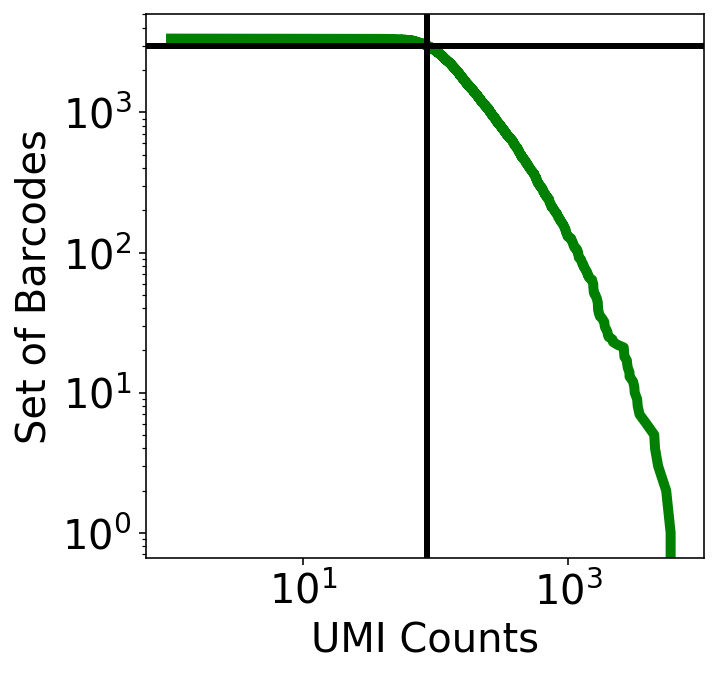

In [0]:
#@title Threshold cells according to knee plot { run: "auto", vertical-output: true }
expected_num_cells = 3000#@param {type:"integer"}
knee = np.sort(nd(adata.X.sum(axis=1)))[::-1]

fig, ax = plt.subplots(figsize=(5, 5))

x = knee
y = range(len(knee))

ax.loglog(x, y, linewidth=5, color="g")

ax.axvline(x=knee[expected_num_cells], linewidth=3, color="k")
ax.axhline(y=expected_num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.show()

### Examine the saturation of the library

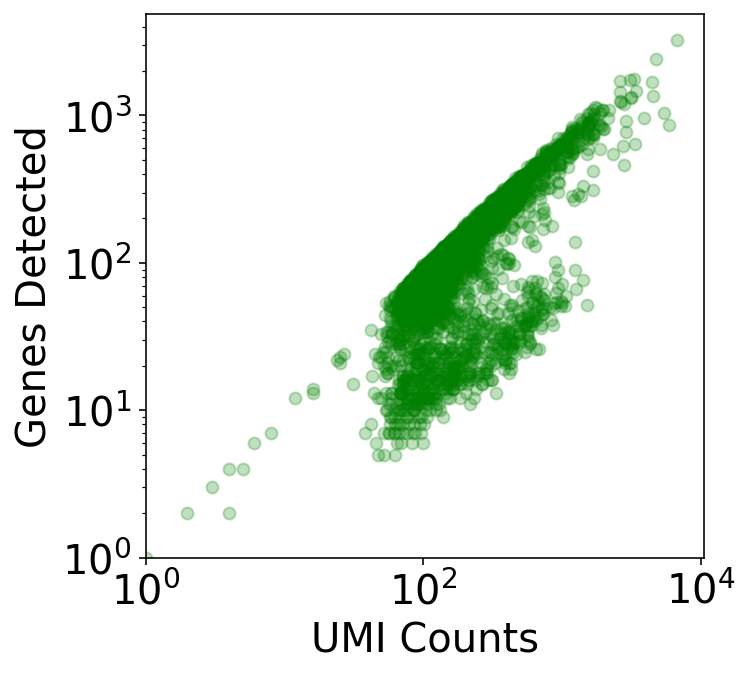

In [0]:
# Create a plot showing genes detected as a function of UMI counts.
fig, ax = plt.subplots(figsize=(5, 5))

x = nd(adata.X.sum(axis=1))
y = nd(np.sum(adata.X>0, axis=1))

ax.scatter(x, y, color="green", alpha=0.25)

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim(1)
ax.set_ylim(1)

plt.show()

This plot is very misleading, as even the small alpha can't accurately show how many points are stacked at one location (This takes about a minute to run since there are a lot of points)

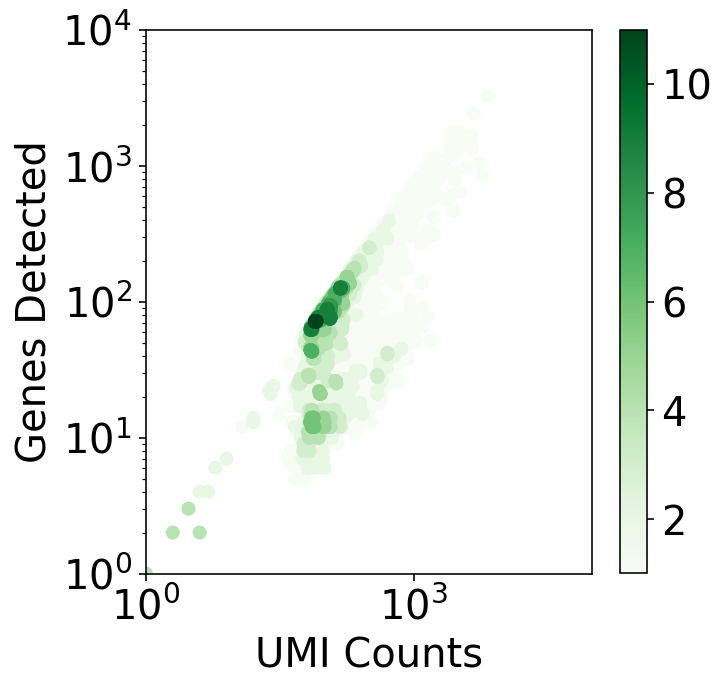

In [0]:
fig, ax = plt.subplots(figsize=(5,5))

#histogram definition
bins = [1500, 1500] # number of bins

# histogram the data
hh, locx, locy = np.histogram2d(x, y, bins=bins)

# Sort the points by density, so that the densest points are plotted last
z = np.array([hh[np.argmax(a<=locx[1:]),np.argmax(b<=locy[1:])] for a,b in zip(x,y)])
idx = z.argsort()
x2, y2, z2 = x[idx], y[idx], z[idx]

s = ax.scatter(x2, y2, c=z2, cmap='Greens')  
fig.colorbar(s, ax=ax)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")

ax.set_xlim(1, 10**5)
ax.set_ylim(1, 10**4)

plt.show()

### Examine the mitochondrial content per cell

It is useful to examine mitochondrial genes, which are important for quality control. [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics) write that

> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

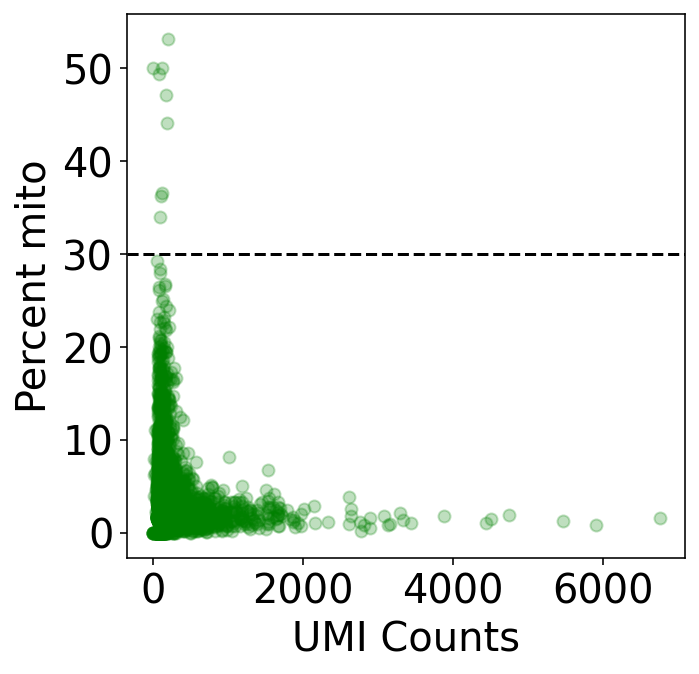

In [0]:
fig, ax = plt.subplots(figsize=(5,5))

x = nd(adata.obs["cell_counts"])
y = nd(adata.obs["percent_mito"])

ax.scatter(x, y, color="green", alpha=0.25)

ax.axhline(y=mito_criteria, linestyle="--", color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Percent mito")

plt.show()

## Filter the anndata

In [0]:
adata.obs["pass_count_filter"] = adata.obs["cell_counts"] > cell_threshold
adata.obs["pass_mito_filter"] = adata.obs.percent_mito < mito_criteria
adata.var["pass_gene_filter"] = adata.var["n_cells"] > gene_threshold

In [0]:
cell_mask = np.logical_and(adata.obs["pass_count_filter"].values, adata.obs["pass_mito_filter"].values)
gene_mask = adata.var["pass_gene_filter"].values

In [0]:
print("Current Shape: {:,} cells x {:,} genes".format(adata.shape[0], adata.shape[1]))
print("    New shape: {:,} cells x {:,} genes".format(cell_mask.sum(), gene_mask.sum()))

Current Shape: 3,362 cells x 55,421 genes
    New shape: 2,725 cells x 12,515 genes


In [0]:
data = adata[cell_mask, gene_mask]

In [0]:
data

View of AnnData object with n_obs × n_vars = 2725 × 12515 
    obs: 'cell_counts', 'n_genes', 'percent_mito', 'pass_count_filter', 'pass_mito_filter'
    var: 'gene_id', 'gene_name', 'gene_counts', 'n_cells', 'pass_gene_filter'

Keep in mind that the values in the `obs` and `var` are from the pre-filtered adata.

## Analysis

Show those genes that yield the highest fraction of counts across cells.

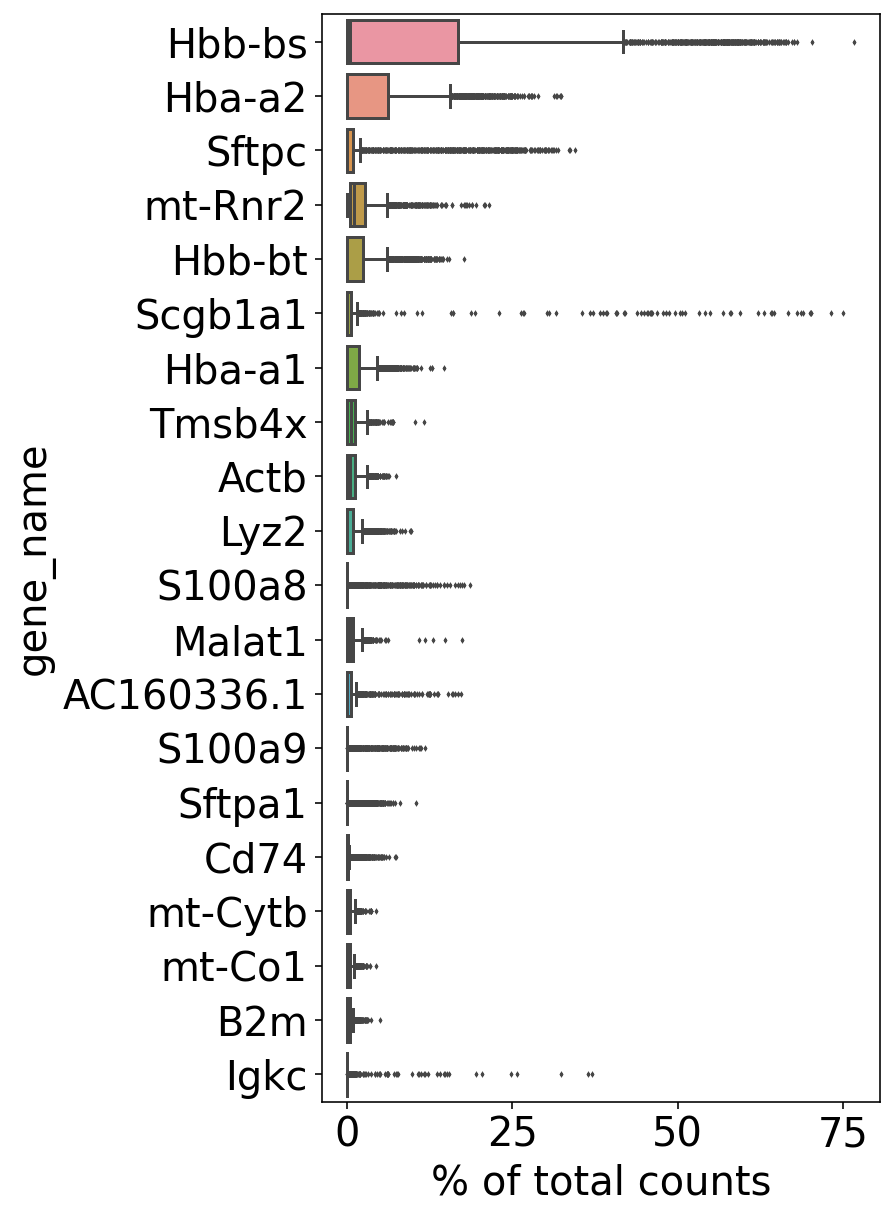

In [0]:
fig, ax = plt.subplots(figsize=(5, 10))
sc.pl.highest_expr_genes(data, n_top=20, ax = ax)

In [0]:
def vplot(y, ax):
    parts = ax.violinplot(
        y, showmeans=False, showmedians=False,
        showextrema=False)

    mean = y.mean()
    ax.scatter(1, mean, zorder=10, color="white")
    
    x = np.random.normal(1, 0.04, size=len(y))
    ax.scatter(x, y, color="k", s=1)
    
    for pc in parts['bodies']:
        pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    
    ax.set_xticks([1])
    ax.set_xticklabels([""])
    return ax

Plot distributions

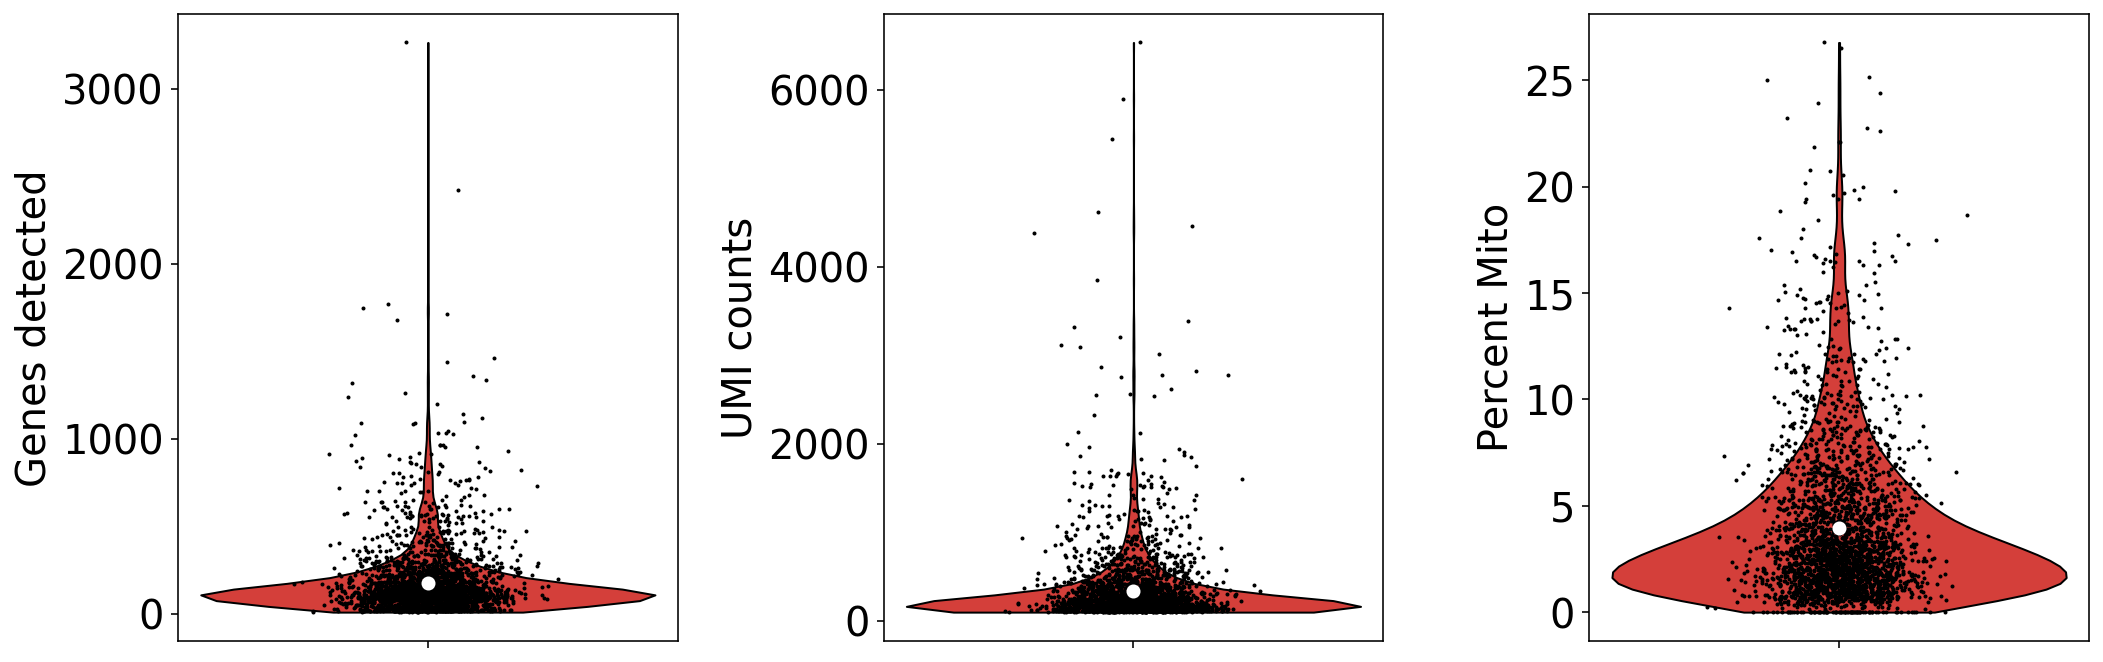

In [0]:
fig, ax = plt.subplots(figsize=(5*3,5), ncols=3)

x1 = data.obs["n_genes"]
x2 = nd(data.X.sum(axis=1))
x3 = data.obs["percent_mito"]

vplot(x1, ax[0])
vplot(x2, ax[1])
vplot(x3, ax[2])

ax[0].set_ylabel("Genes detected")
ax[1].set_ylabel("UMI counts")
ax[2].set_ylabel("Percent Mito")

plt.tight_layout()
plt.show()

# Process the matrix for clustering, visualization, and DE

In [0]:
data.layers["raw"] = data.X

In [0]:
scale_num = 1000000
data.layers["norm"] = normalize(data.X, norm="l1", axis=1)*scale_num

In [0]:
data.layers["log1p"] = np.log1p(data.layers["norm"])
data.uns = OrderedDict([("log1p", {"base":None})])

In [0]:
data.X = data.layers["log1p"]

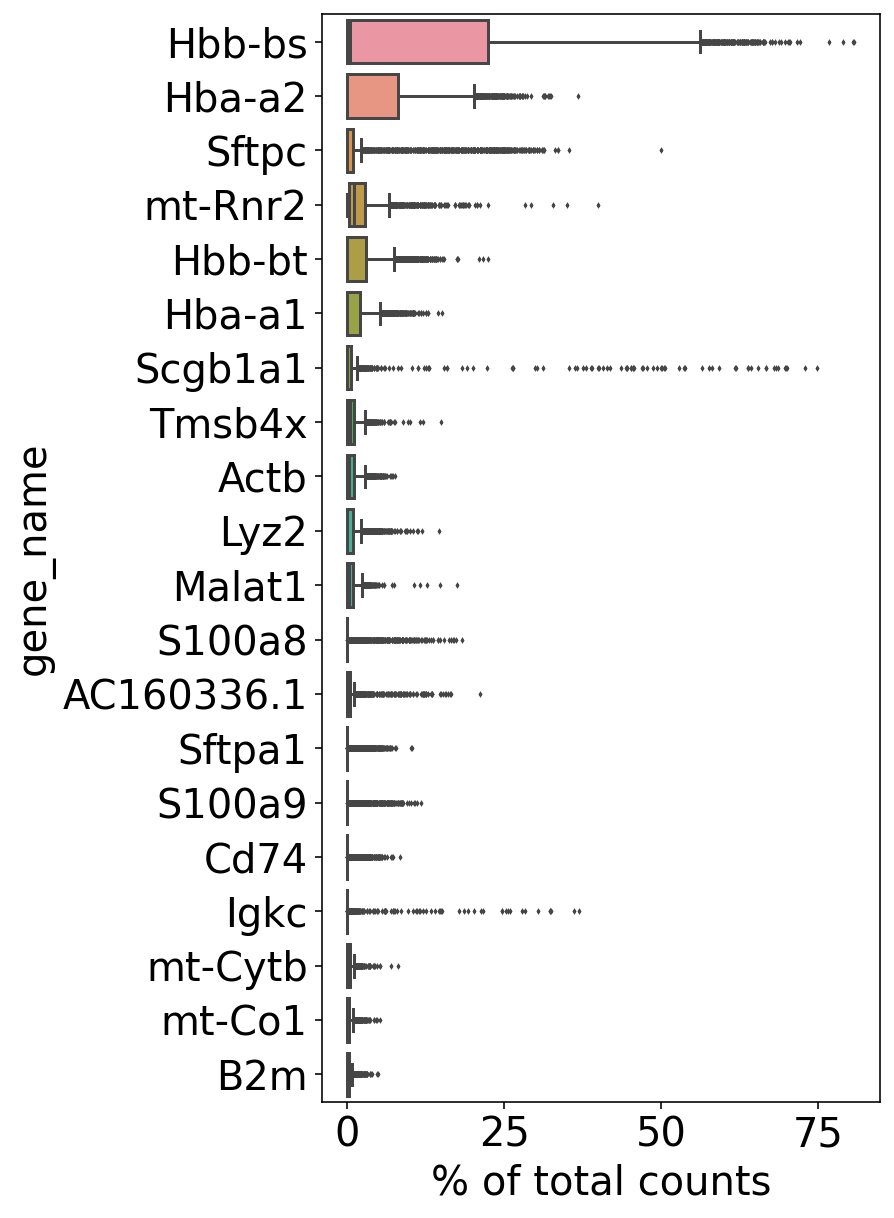

In [0]:
fig, ax = plt.subplots(figsize=(5, 10))
sc.pl.highest_expr_genes(adata, n_top=20, ax=ax)

Detecting highly variable genes is done on the log1p(norm) data

In [0]:
sc.pp.highly_variable_genes(data, n_top_genes=n_top_genes, flavor=flavor, n_bins=n_bins)
hvg_mask = data.var.highly_variable.values

Now we scale the columns of the matrix to unit variance and zero mean

In [0]:
%%time
# Scaling operation cannot be performed on the sparse matrix, so we make a dense matrix
mat = data.layers["log1p"].todense()
data.layers["scale"] = scale(mat, axis=0, with_mean=True, with_std=True, copy=True)
data.X = data.layers["scale"]

del mat

CPU times: user 1.01 s, sys: 73.4 ms, total: 1.08 s
Wall time: 1.09 s


# Generating visualizations

## PCA on highly variable genes

In [0]:
%%time
# PCA
X = data.X[:,hvg_mask]

tsvd = TruncatedSVD(n_components=num_PCA)
data.obsm["X_pca"] = tsvd.fit_transform(X)

CPU times: user 1.93 s, sys: 182 ms, total: 2.11 s
Wall time: 1.15 s


## Clustering

In [0]:
sc.pp.neighbors(data, n_neighbors=n_neighbors, n_pcs=num_PCA, random_state=state)

In [0]:
sc.tl.leiden(data, random_state=state)

## Dimensionality reduction

In [0]:
# TSNE
X = data.obsm["X_pca"]

tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
data.obsm["X_pca_tsne"] = tsne.fit_transform(X)

In [0]:
# NCA
X = data.X
y = data.obs.leiden.values # you could use louvain here also

nca = NeighborhoodComponentsAnalysis(n_components=num_NCA,random_state=state)
data.obsm["X_nca"] = nca.fit_transform(X, y)

In [0]:
# TSNE the NCA
X = data.obsm["X_nca"]
tsne = TSNE(n_components=num_TSNE, metric=metric, random_state=state)
data.obsm["X_nca_tsne"] = tsne.fit_transform(X)

# Visualize

## TSNE of PCA

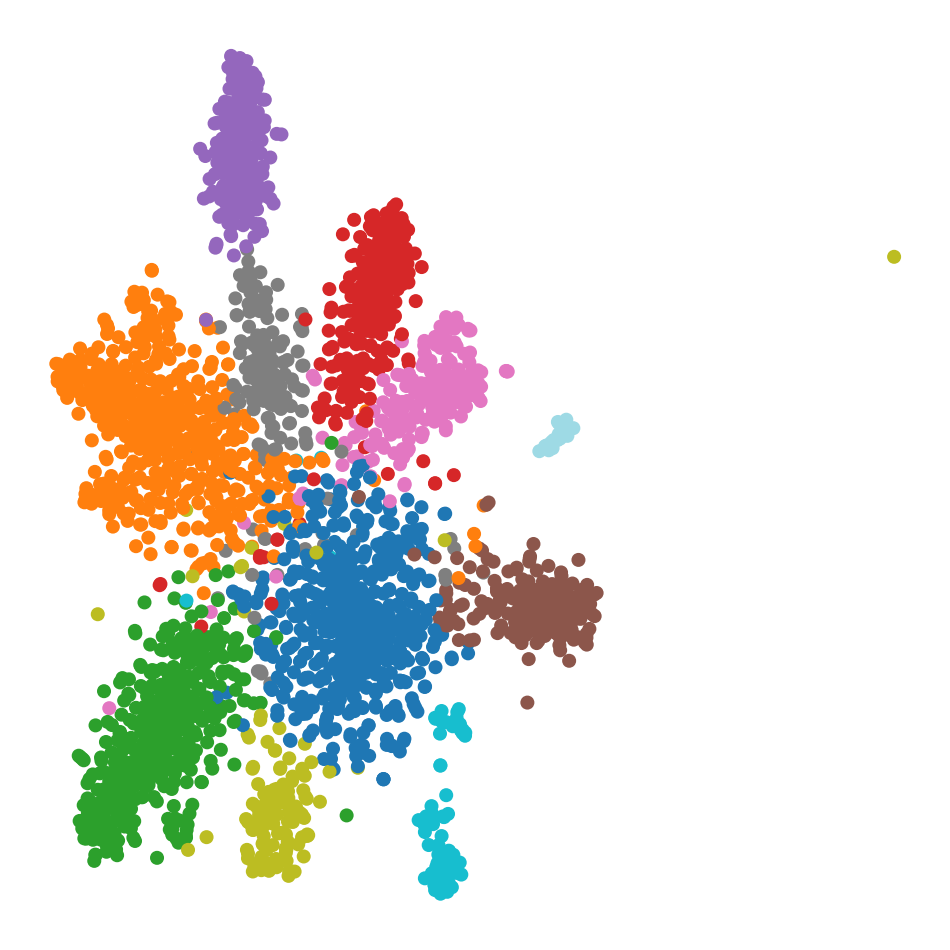

In [0]:
fig, ax = plt.subplots(figsize=(7,7))

x = data.obsm["X_pca_tsne"][:,0]
y = data.obsm["X_pca_tsne"][:,1]
c = data.obs["leiden"].astype(int)

ax.scatter(x, y, c = c, cmap='tab20')

ax.set_axis_off()

plt.tight_layout()
plt.show()

## TSNE of NCA

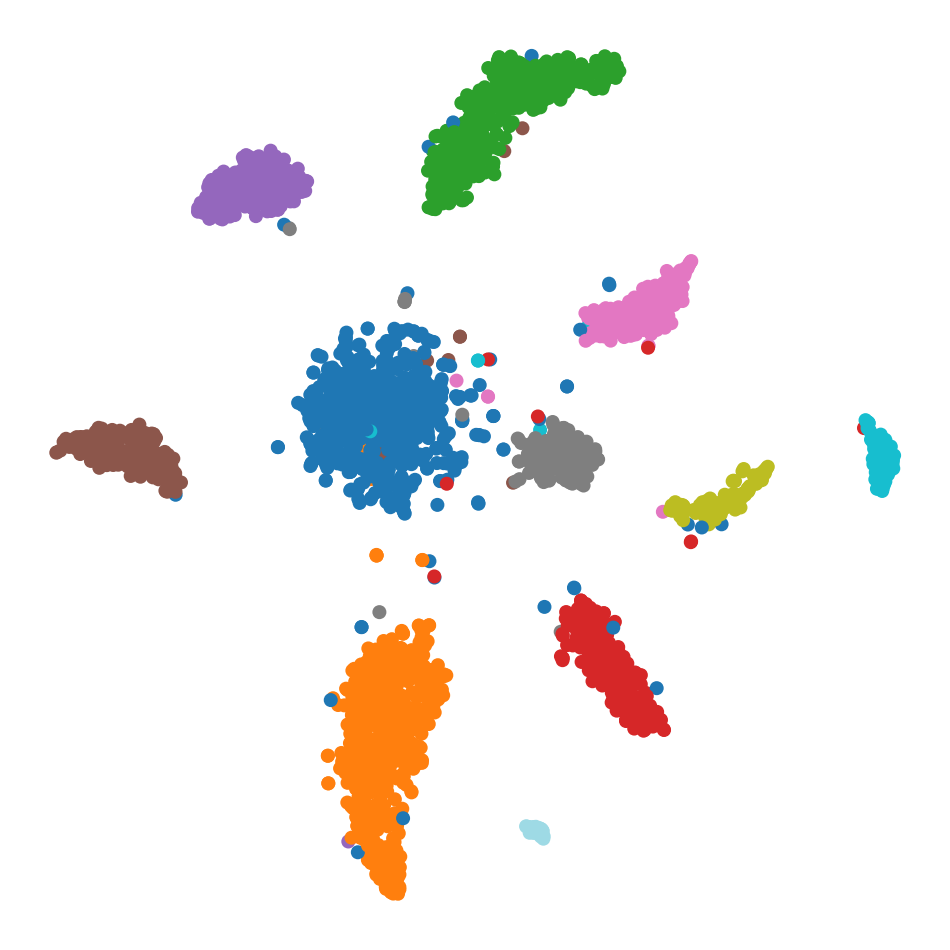

In [0]:
fig, ax = plt.subplots(figsize=(7,7))

x = data.obsm["X_nca_tsne"][:,0]
y = data.obsm["X_nca_tsne"][:,1]
c = data.obs["leiden"].astype(int)

ax.scatter(x, y, c = c, cmap='tab20')

ax.set_axis_off()

plt.tight_layout()
plt.show()

### Find marker genes

A key aspect of annotating a cell atlas is identifying "marker genes". These are genes specific to individual clusters that "mark" them, and are important both for assigning functions to cell clusters, and for designing downstream experiments to probe activity of clusters. 

A gene marker analysis begins with ranking genes in each cluster according to how different they are relative to other clusters. Typically the t-test is used for this purpose.

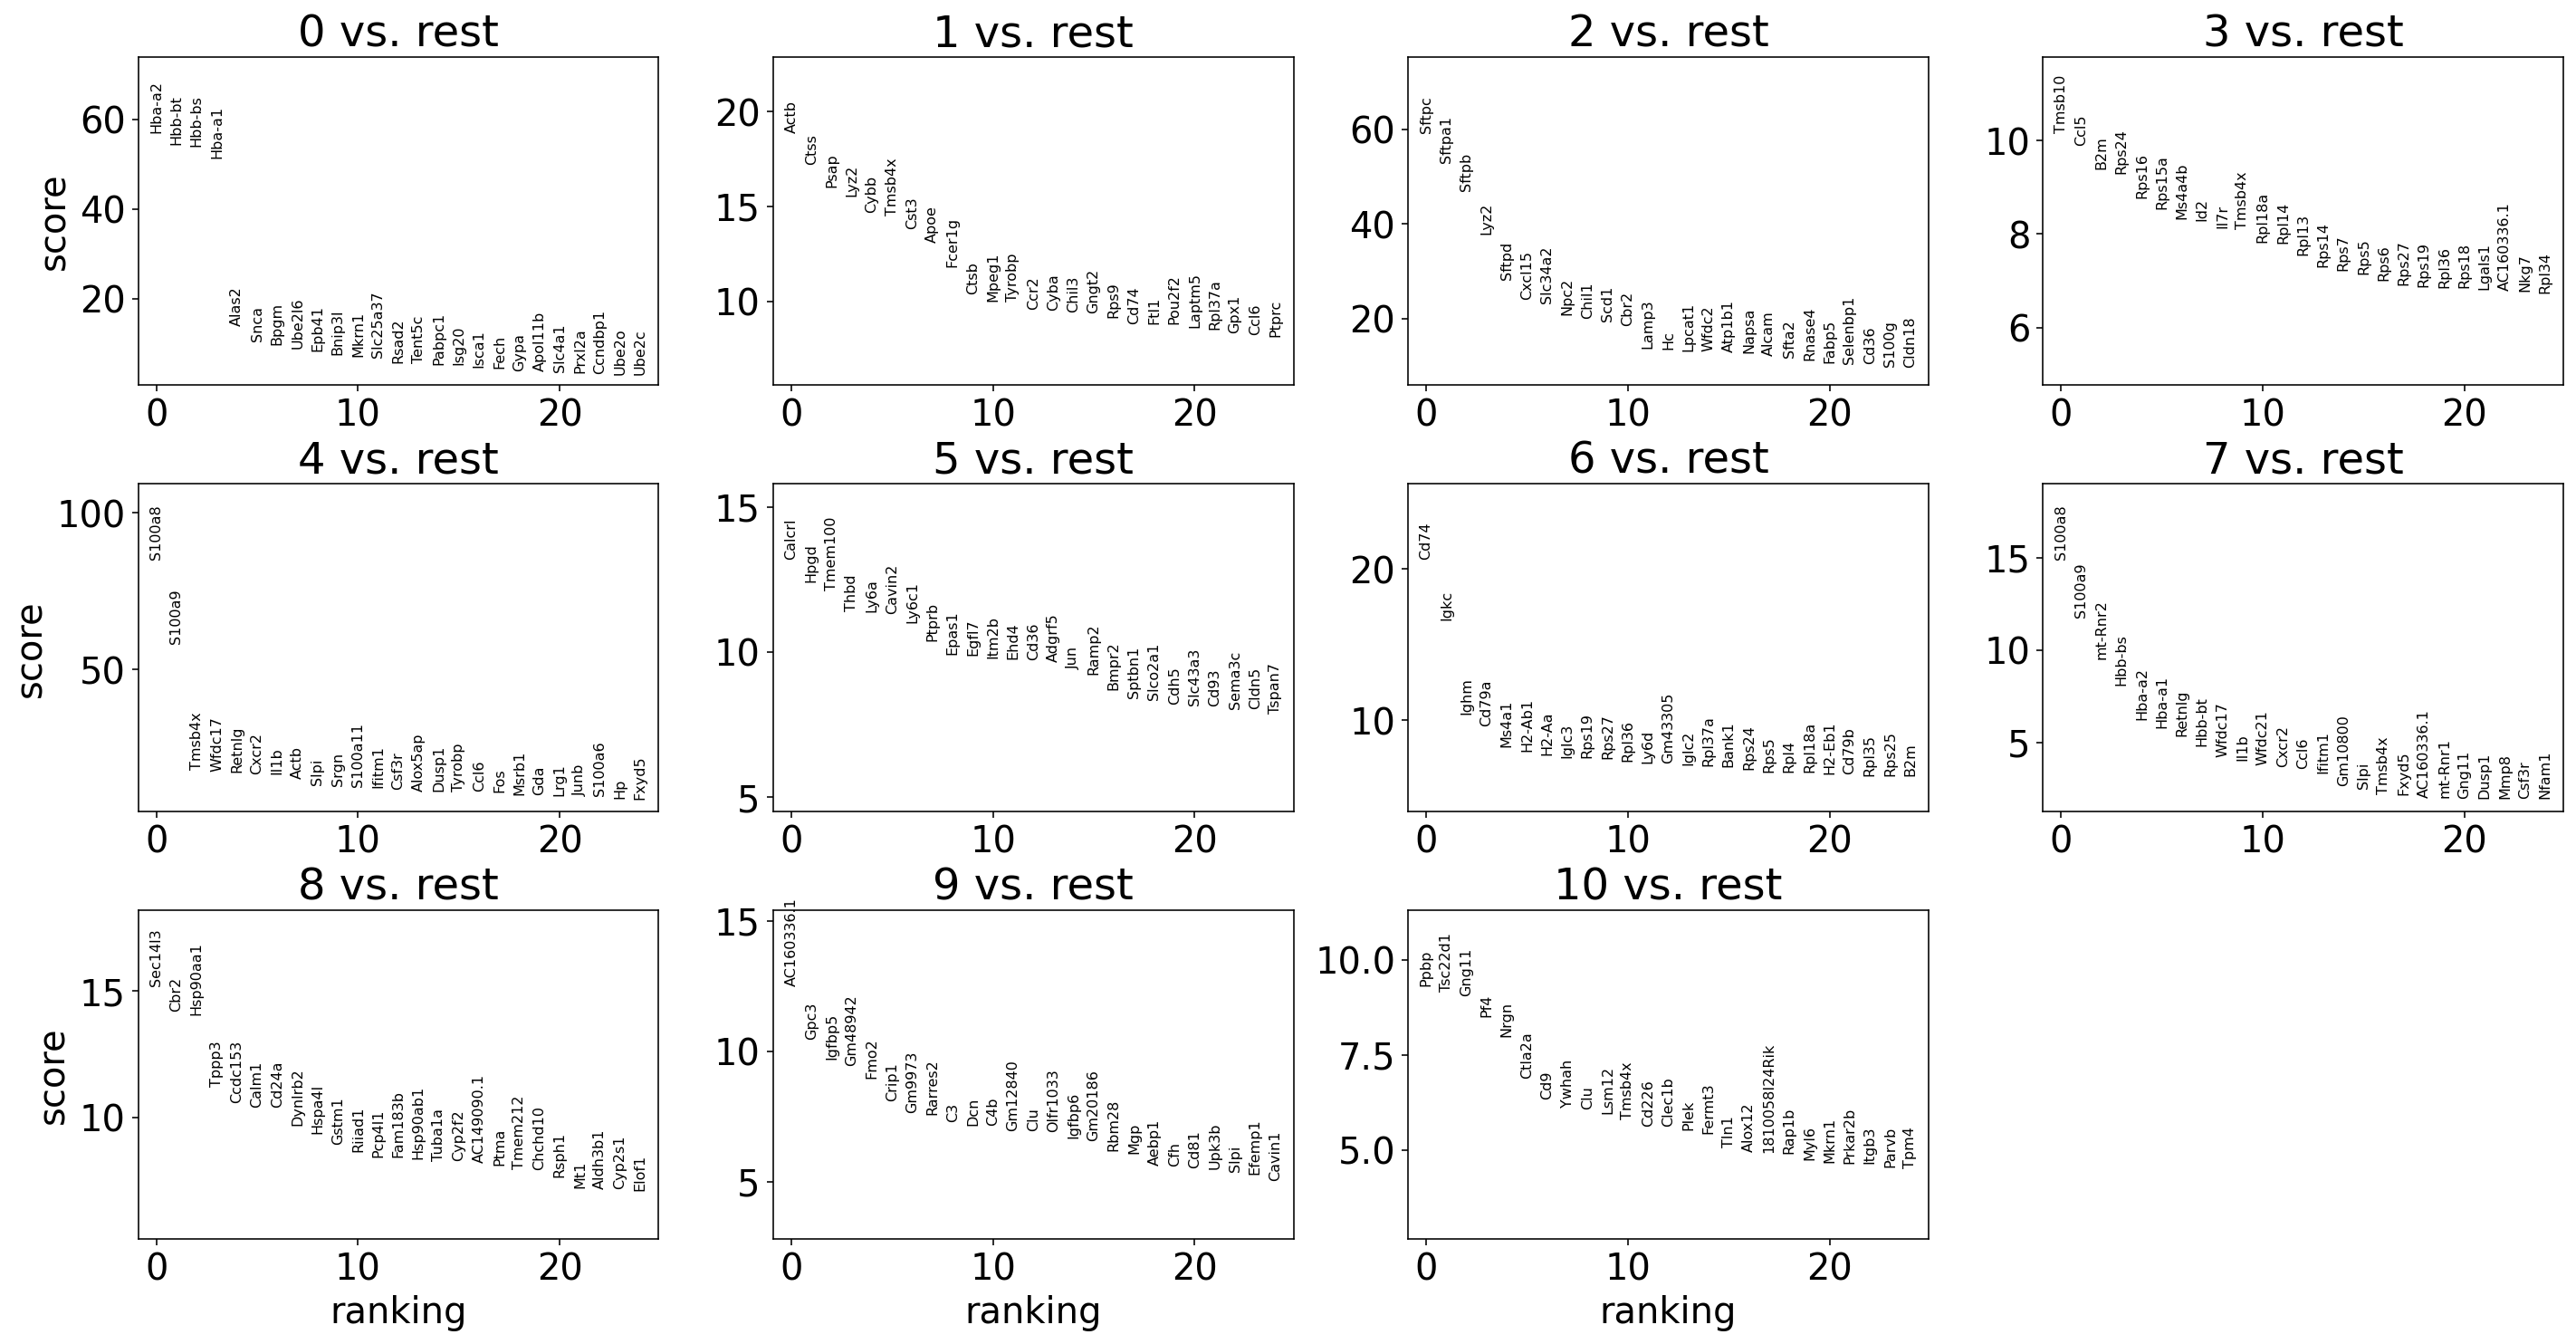

In [0]:
sc.tl.rank_genes_groups(data, 'leiden', method='t-test', corr_method="bonferroni")
sc.pl.rank_genes_groups(data, n_genes=25, sharey=False)

An alternative to the parametric t-test is the non-parametric [Wilcoxon rank-sum (Mann-Whitney-U)](https://de.wikipedia.org/wiki/Wilcoxon-Mann-Whitney-Test) test.

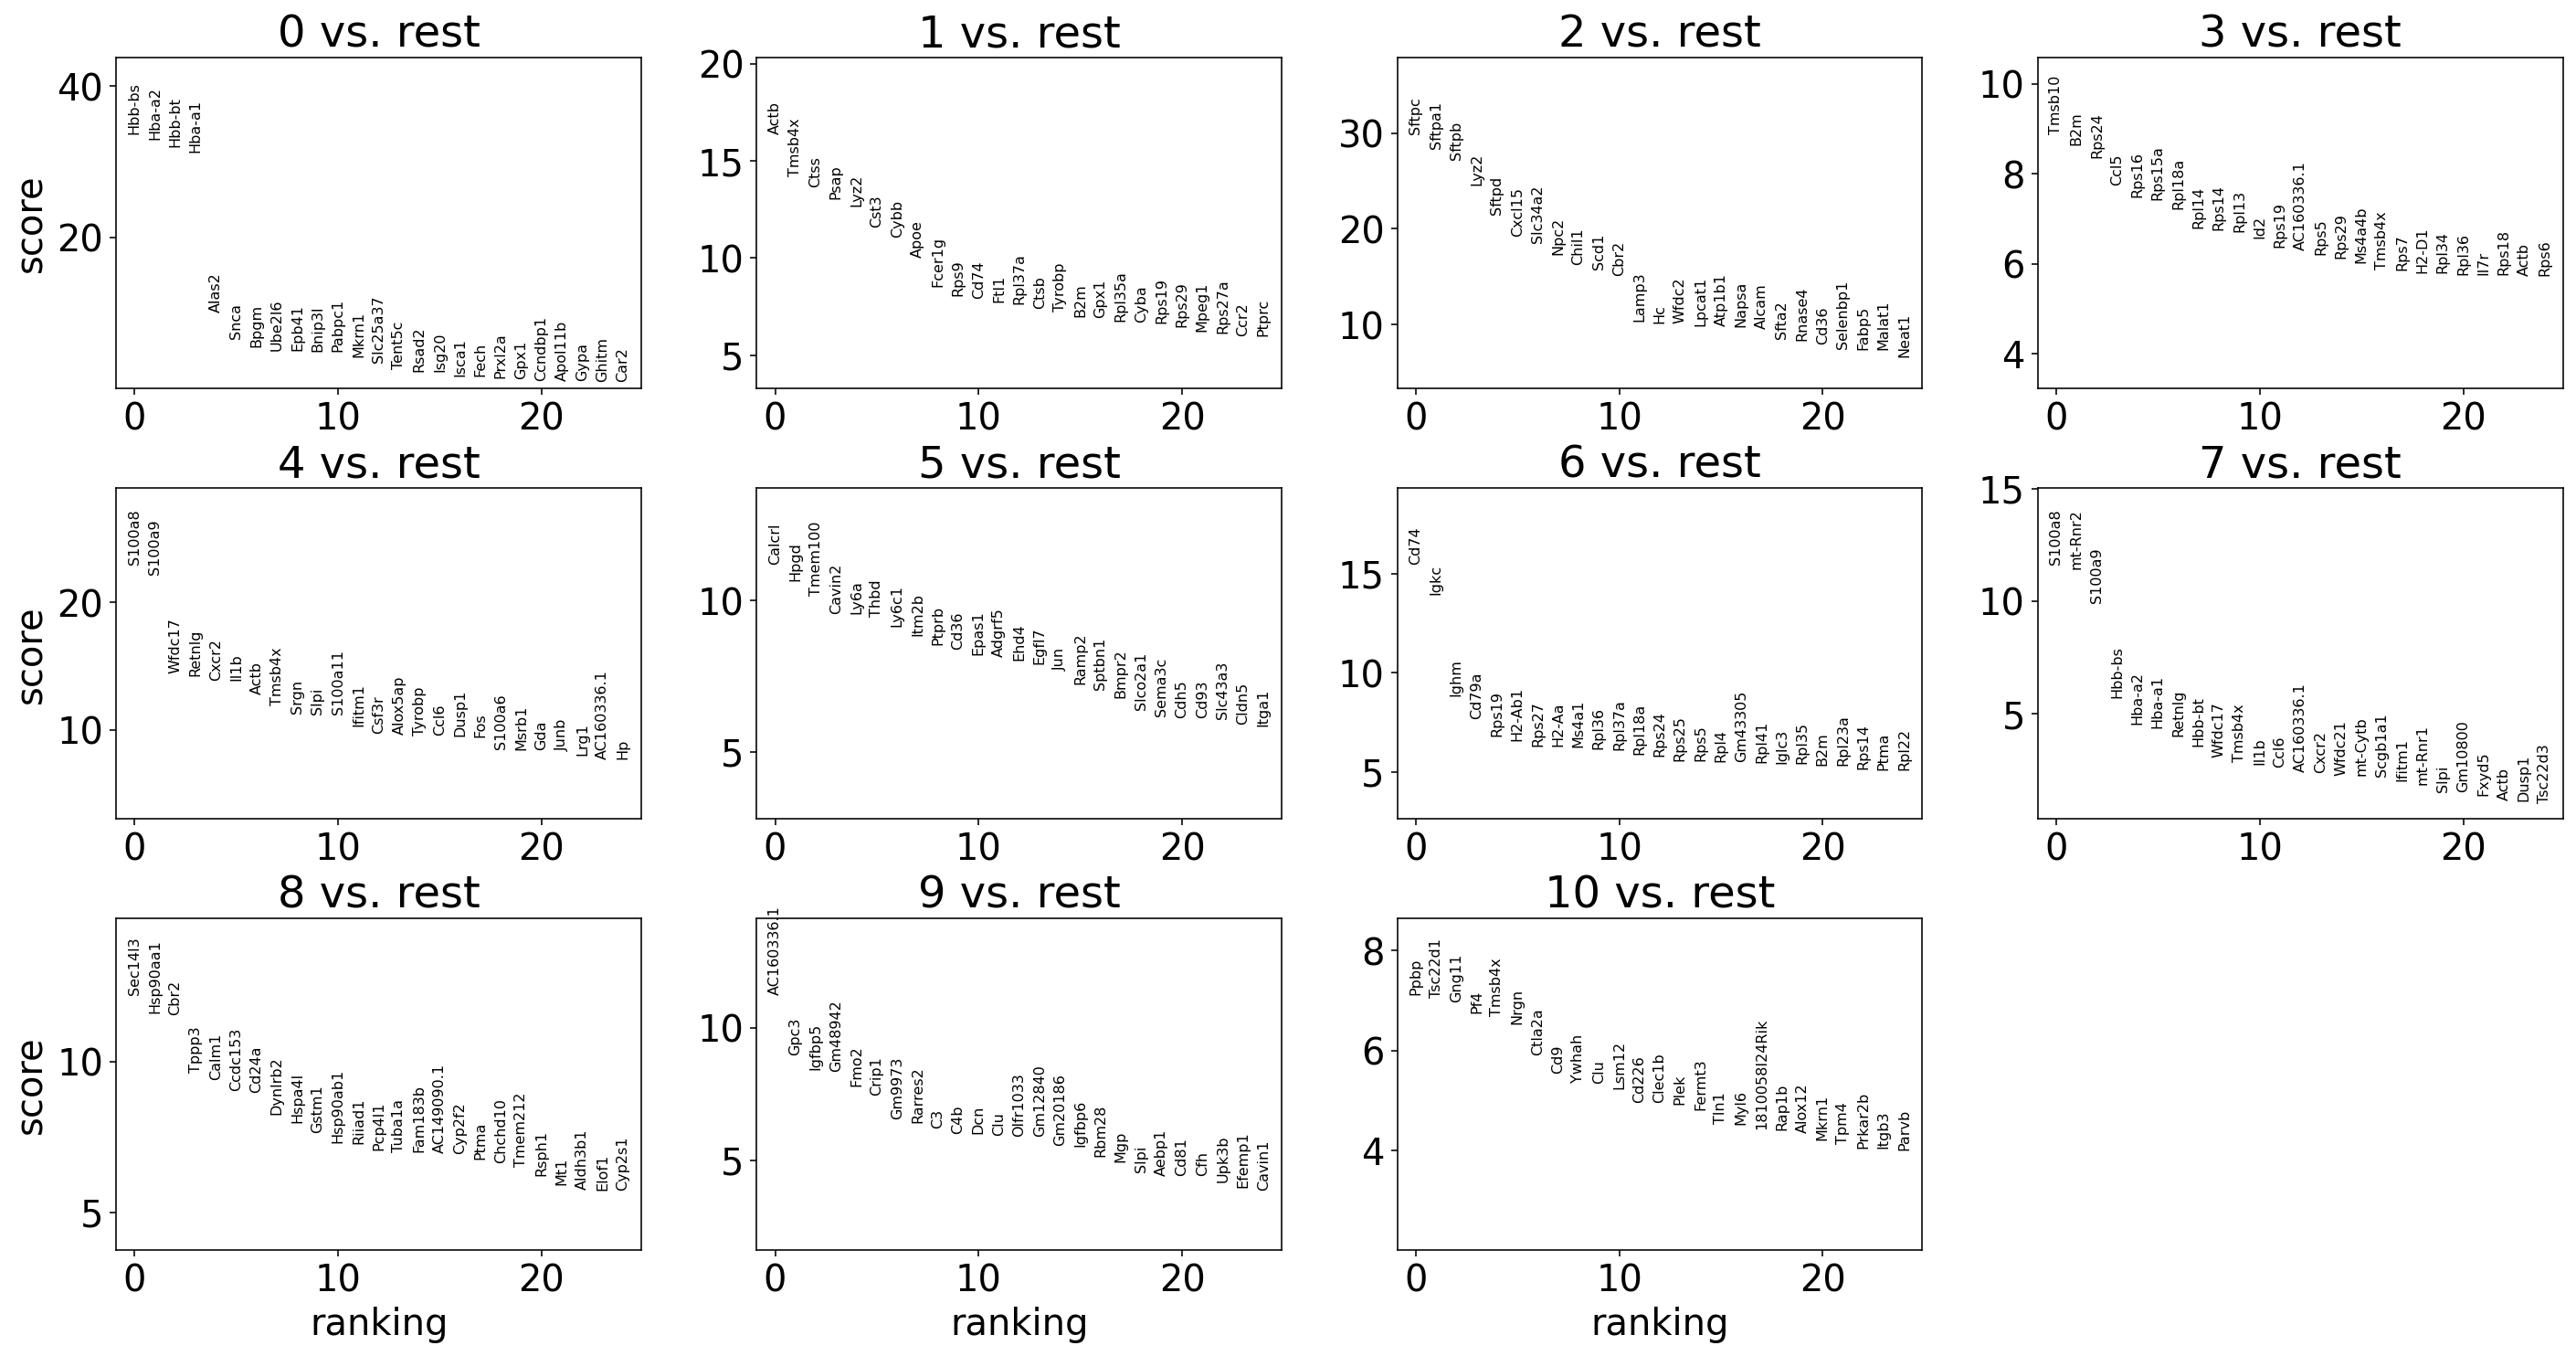

In [0]:
sc.tl.rank_genes_groups(data, 'leiden', method='wilcoxon', corr_method="bonferroni")
sc.pl.rank_genes_groups(data, n_genes=25, sharey=False)

As an alternative, genes can be ranked using logistic regression (see [Natranos et al. (2018)](https://doi.org/10.1101/258566)).

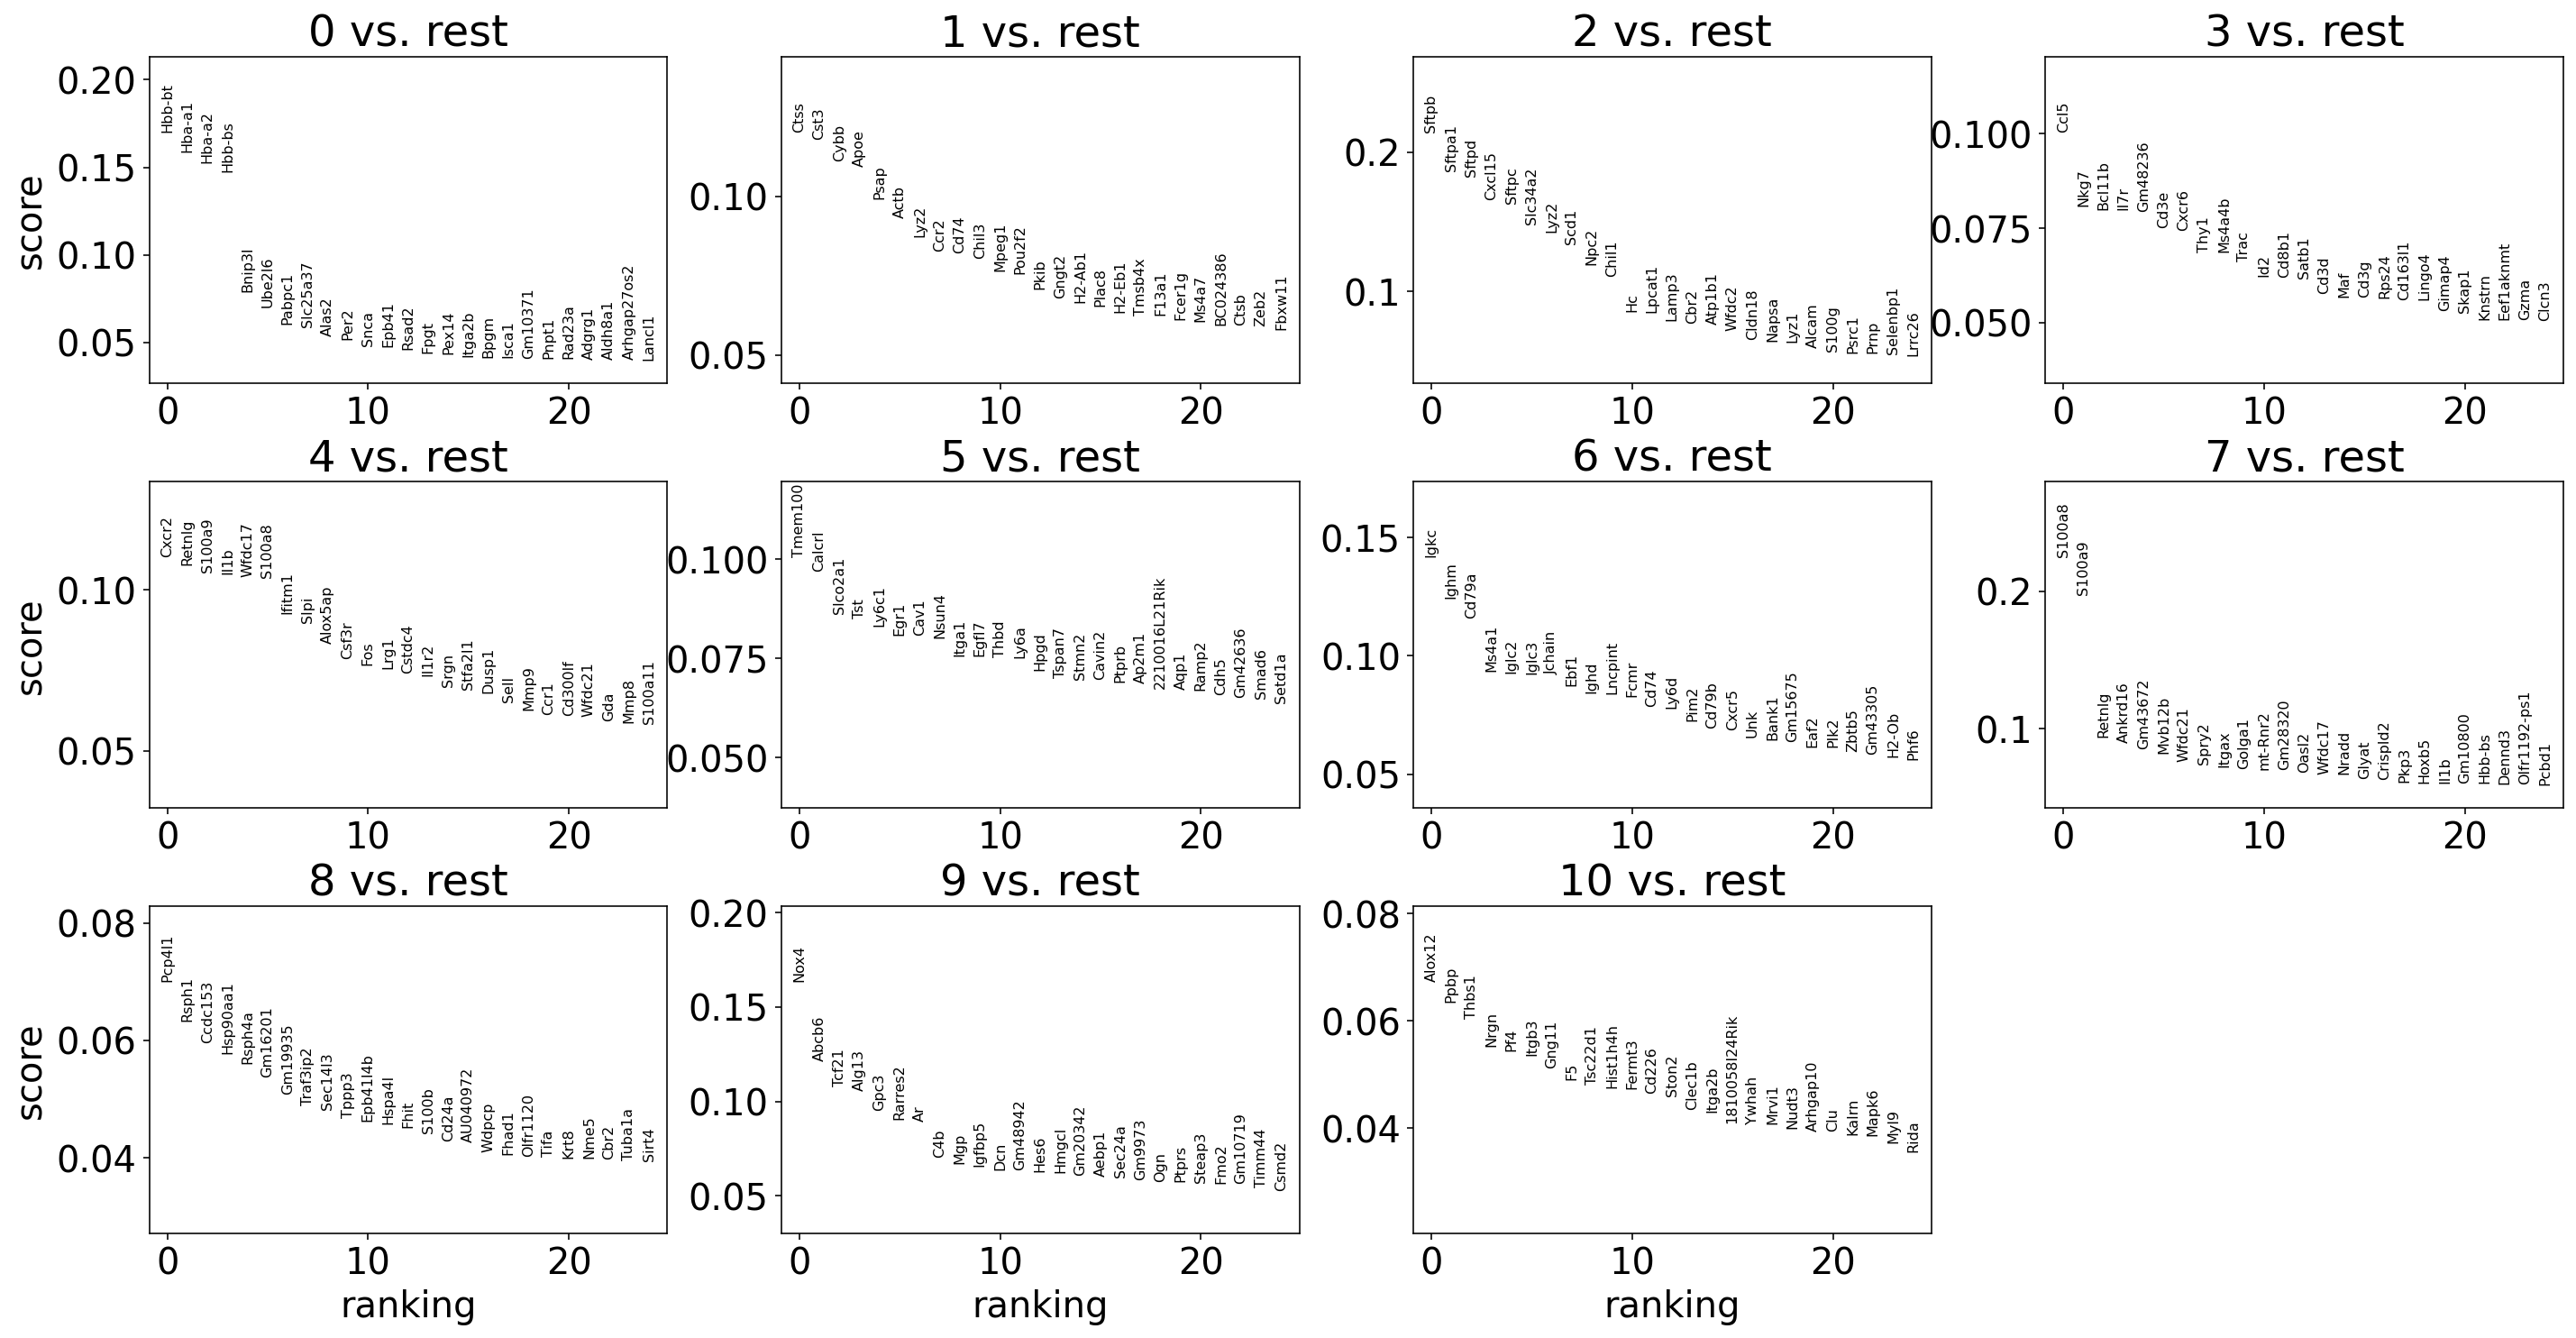

In [0]:
sc.tl.rank_genes_groups(data, 'leiden', method='logreg')
sc.pl.rank_genes_groups(data, n_genes=25, sharey=False)

In [0]:
sc.tl.rank_genes_groups(data, 'leiden', method='wilcoxon', corr_method="bonferroni")

Show the 10 top ranked genes per cluster in a dataframe.

In [0]:
pd.DataFrame(data.uns['rank_genes_groups']['names']).head(10)

0       1        2       3  ...        7         8           9       10
0  Hbb-bs    Actb    Sftpc  Tmsb10  ...   S100a8   Sec14l3  AC160336.1     Ppbp
1  Hba-a2  Tmsb4x   Sftpa1     B2m  ...  mt-Rnr2  Hsp90aa1        Gpc3  Tsc22d1
2  Hbb-bt    Ctss    Sftpb   Rps24  ...   S100a9      Cbr2      Igfbp5    Gng11
3  Hba-a1    Psap     Lyz2    Ccl5  ...   Hbb-bs     Tppp3     Gm48942      Pf4
4   Alas2    Lyz2    Sftpd   Rps16  ...   Hba-a2     Calm1        Fmo2   Tmsb4x
5    Snca    Cst3   Cxcl15  Rps15a  ...   Hba-a1   Ccdc153       Crip1     Nrgn
6    Bpgm    Cybb  Slc34a2  Rpl18a  ...   Retnlg     Cd24a      Gm9973   Ctla2a
7  Ube2l6    Apoe     Npc2   Rpl14  ...   Hbb-bt   Dynlrb2     Rarres2      Cd9
8   Epb41  Fcer1g    Chil1   Rps14  ...   Wfdc17    Hspa4l          C3    Ywhah
9  Bnip3l    Rps9     Scd1   Rpl13  ...   Tmsb4x     Gstm1         C4b      Clu

[10 rows x 11 columns]

Get a table with the scores and groups.

In [0]:
genes = pd.DataFrame(data.uns['rank_genes_groups']['names']).to_numpy()
pvals = pd.DataFrame(data.uns['rank_genes_groups']['pvals']).to_numpy()

In [0]:
unique = np.unique(data.obs.leiden.values.astype(int)).astype(str)
markers_gene = pd.DataFrame(index=unique, columns=["gene_name", "p_value"])

In [0]:
for un, u in enumerate(unique):
    g = genes[:,un]
    p = pvals[:,un]
    markers_gene.loc[u]["gene_name"]  = g.tolist()
    markers_gene.loc[u]["p_value"] = p.tolist()

In [0]:
markers_gene = markers_gene.apply(pd.Series.explode).reset_index()
markers_gene = markers_gene.rename(columns={"index":'leiden'})

In [0]:
markers_gene.drop_duplicates(["leiden"]) # just showing the top candidate per cluster

leiden   gene_name       p_value
0         0      Hbb-bs  1.20785e-248
100       1        Actb   2.35398e-60
200       2       Sftpc  1.06086e-196
300       3      Tmsb10   6.18371e-19
400       4      S100a8  6.45557e-117
500       5      Calcrl   4.54132e-29
600       6        Cd74   6.85396e-54
700       7      S100a8   2.94236e-31
800       8     Sec14l3   2.41253e-34
900       9  AC160336.1    2.3292e-29
1000     10        Ppbp   1.12025e-12

In [0]:
def vplot_de(x, unique, specific_gene, specific_cluster, ax):
    unique = unique.astype(str)
    labels = unique
    lidx = np.arange(1, len(labels)+1)  # the label locations
    midx = np.where(unique==specific_cluster)[0][0]
    
    
    parts = ax.violinplot(x, showmedians=False, showextrema=False)
    for pcidx, pc in enumerate(parts['bodies']):
        pc.set_facecolor('grey')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        if pcidx == midx:
            pc.set_facecolor('#D43F3A')
            
    mean = [np.mean(i) for i in x]
    ax.scatter(lidx, mean, marker='o', color='white', s=30, zorder=3)
    
    ax.set_ylabel("$log(CPM + 1)$".format(specific_gene))
    ax.set_xticks(lidx)
    ax.set_xticklabels(labels, rotation=0, ha="center")
    ax.set_title("{} gene in cluster {}".format(specific_gene, specific_cluster))
    
    return ax

In [0]:
specific_cluster = markers_gene.drop_duplicates(["leiden"])["leiden"].values
specific_gene = markers_gene.drop_duplicates(["leiden"])["gene_name"].values

In [0]:
unique

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
      dtype='<U21')

### Plot one cluster, gene pair

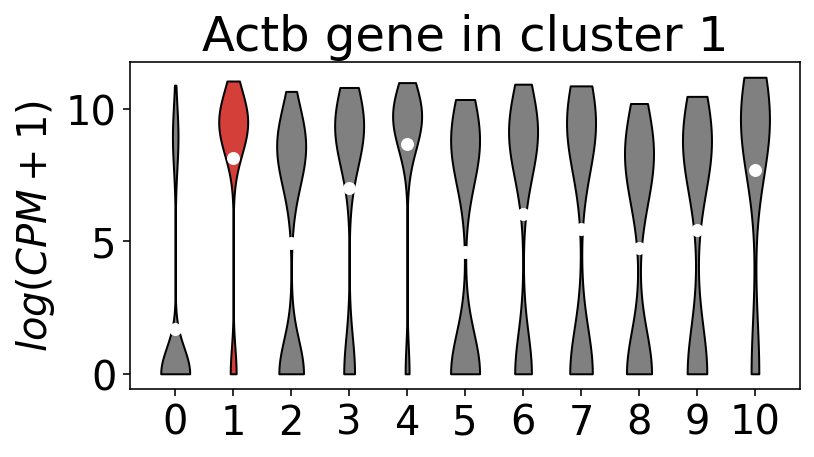

In [0]:
fig, ax = plt.subplots(figsize=(6, 3))

spec_c = specific_cluster[1]
spec_g = specific_gene[1]

x = []
for c in unique:
    x.append(nd(data[data.obs.leiden==str(c)][:,data.var.gene_name==spec_g].layers["log1p"].todense()).tolist())
    
vplot_de(x, unique, spec_g, spec_c, ax=ax)

ax.set_ylabel("$log(CPM+1)$")

plt.show()

### Plot all cluster gene pairs

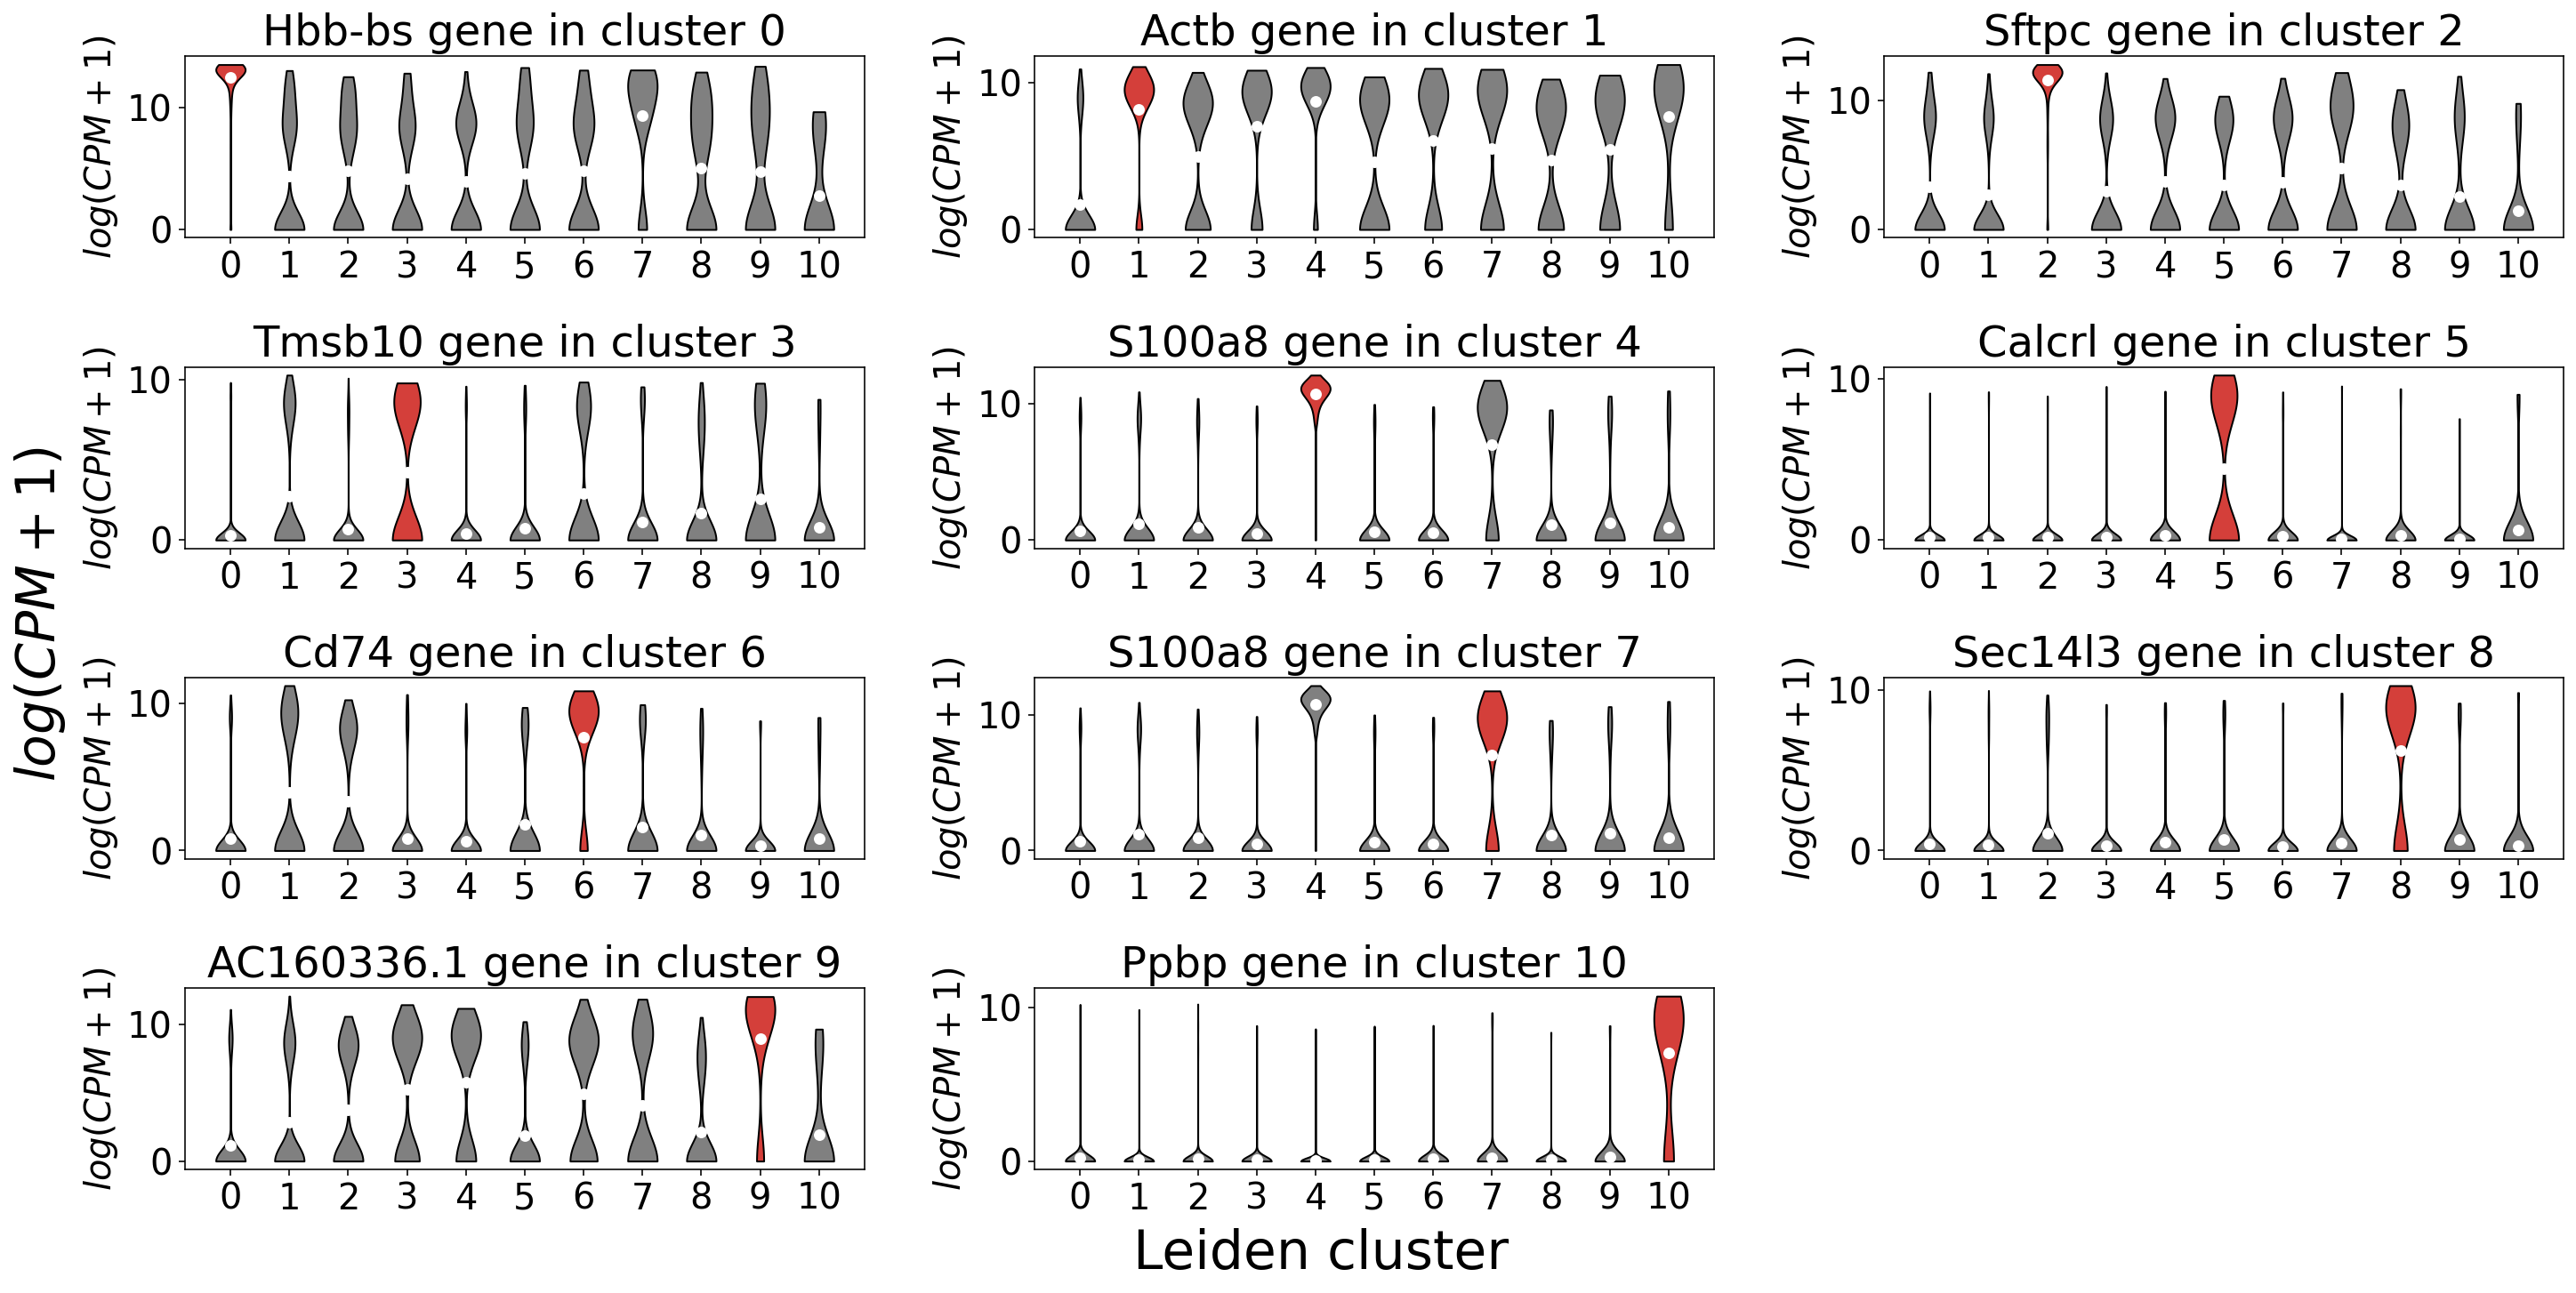

In [0]:
length = len(specific_cluster)*5
height = 3

fig, ax = plt.subplots(figsize=(20,10), ncols = 3, nrows=4)

axs = trim_axs(ax, len(specific_cluster))

for sn, (spec_c, spec_g) in enumerate(zip(specific_cluster, specific_gene)):
    x = []
    for c in unique:
        x.append(nd(data[data.obs.leiden==str(c)][:,data.var.gene_name==spec_g].layers["log1p"].todense()).tolist())
        
    vplot_de(x, unique, spec_g, spec_c, ax=axs[sn])
    
    
fig.text(0.5, 0, 'Leiden cluster', ha='center', va='center', fontsize=30)
fig.text(0, 0.5, '$log(CPM +1)$', ha='center', va='center', rotation='vertical', fontsize=30)
plt.tight_layout()

plt.show()

# Visualize expression patterns of a specific marker gene

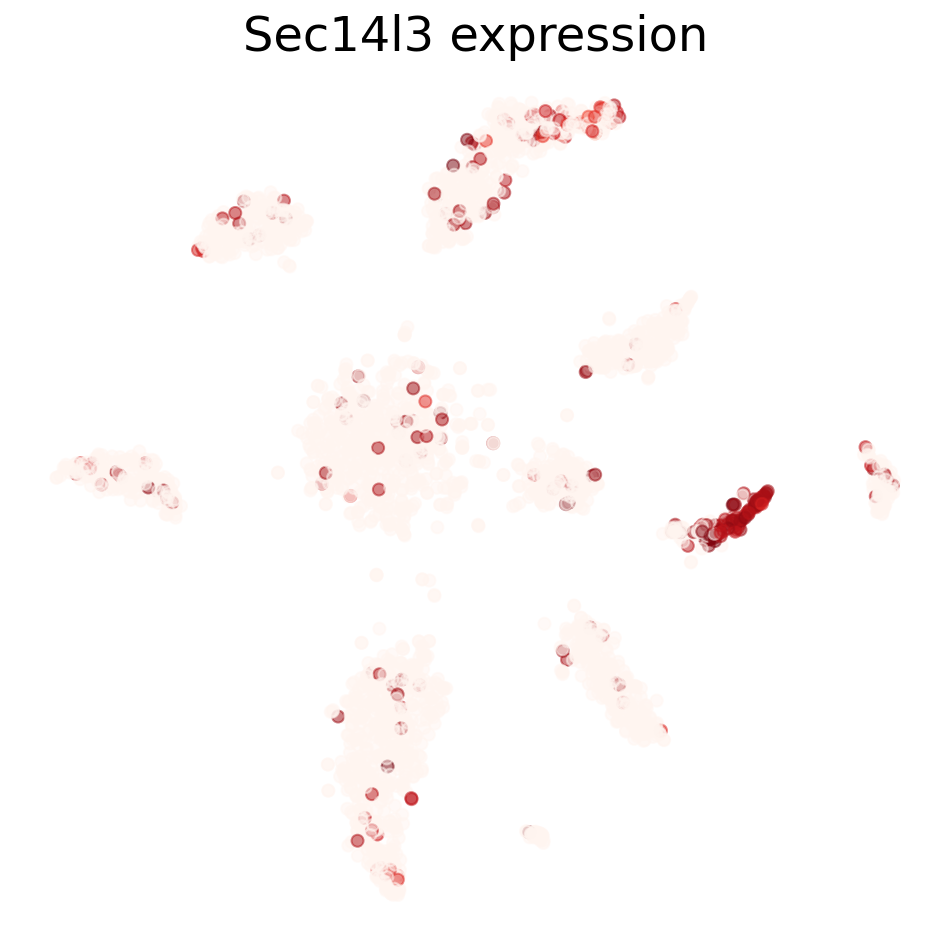

In [0]:
gene = "Sec14l3"

fig, ax = plt.subplots(figsize=(7,7))

x = data.obsm["X_nca_tsne"][:,0]
y = data.obsm["X_nca_tsne"][:,1]
c = nd(data.layers["log1p"].todense()[:,data.var.gene_name==gene])

ax.scatter(x, y, c = c, cmap='Reds', alpha=0.5)

ax.set_axis_off()
ax.set_title("{} expression".format(gene))
plt.tight_layout()
plt.show()

## Annotate clusters

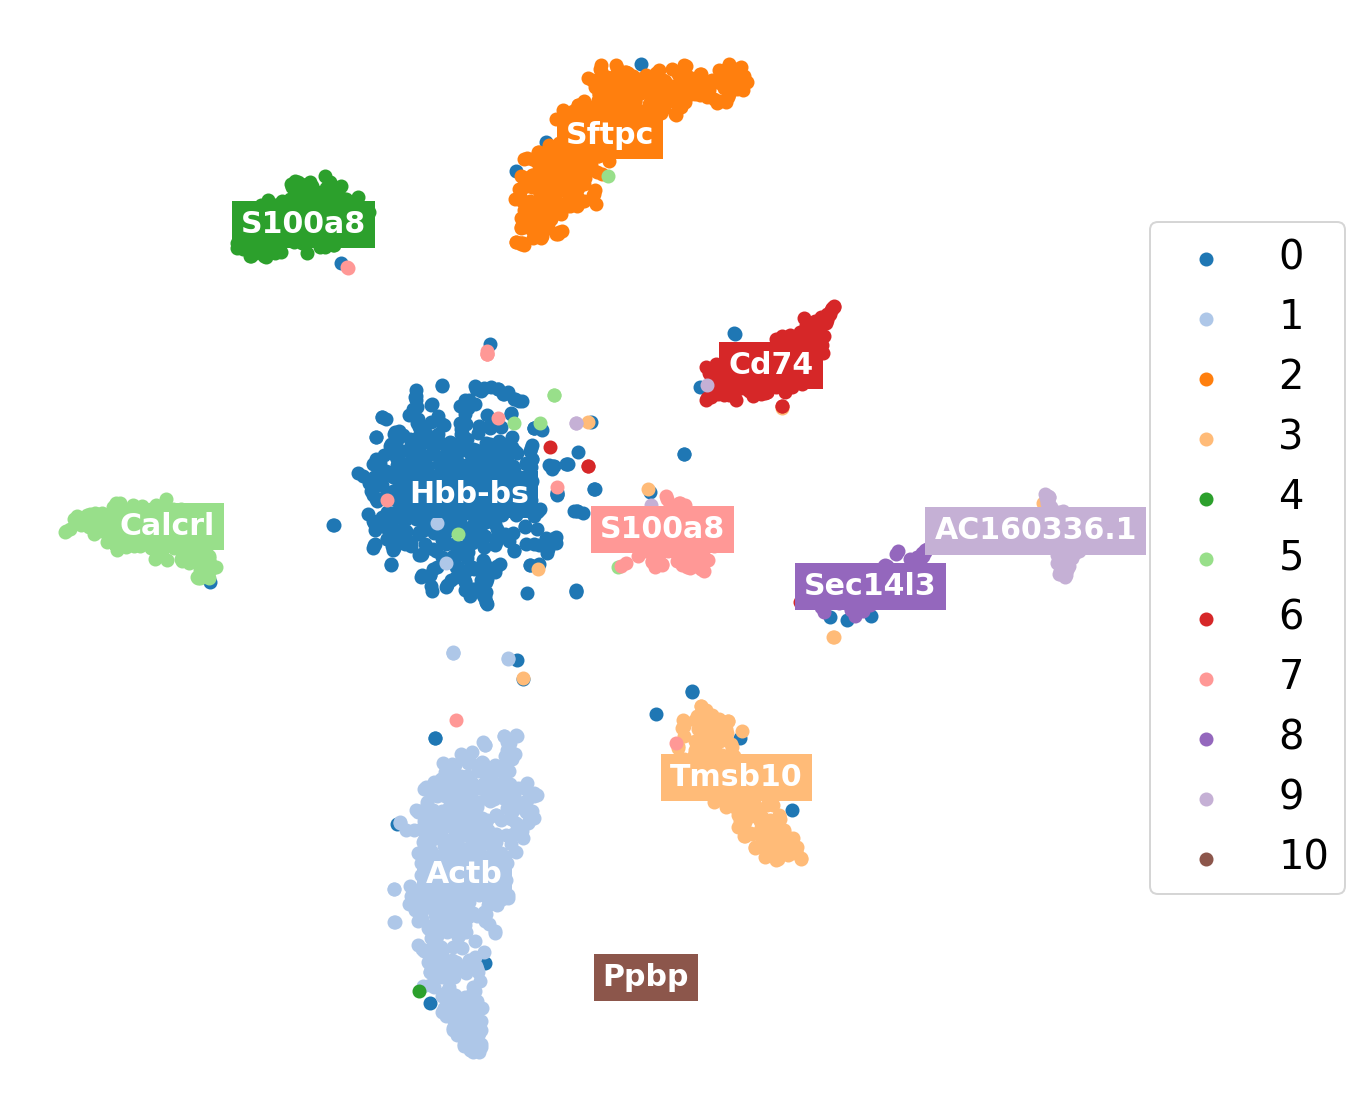

In [0]:
fig, ax = plt.subplots(figsize=(10,10))

c = np.unique(data.obs["leiden"].values.astype(int)).astype(str)
cmap = cm.get_cmap("tab20")

for idx, (cluster, gene) in enumerate(zip(c, specific_gene)):
    XX = data[data.obs.leiden == cluster,:].obsm["X_nca_tsne"]
    
    x = XX[:,0]
    y = XX[:,1]
    ax.scatter(x, y, color = cmap(idx), label=cluster)
    ax.annotate(gene, 
             (np.mean(x), np.mean(y)),
             horizontalalignment='center',
             verticalalignment='center',
             size=15, weight='bold',
             color="white",
               backgroundcolor=cmap(idx)) 
    

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_axis_off()
plt.show()

In [0]:
top_idx = [np.where(i == data.var.gene_name.values)[0][0] for i in specific_gene]

In [0]:
mat = data.layers["norm"].todense()
obs = data.obs
var = data.var

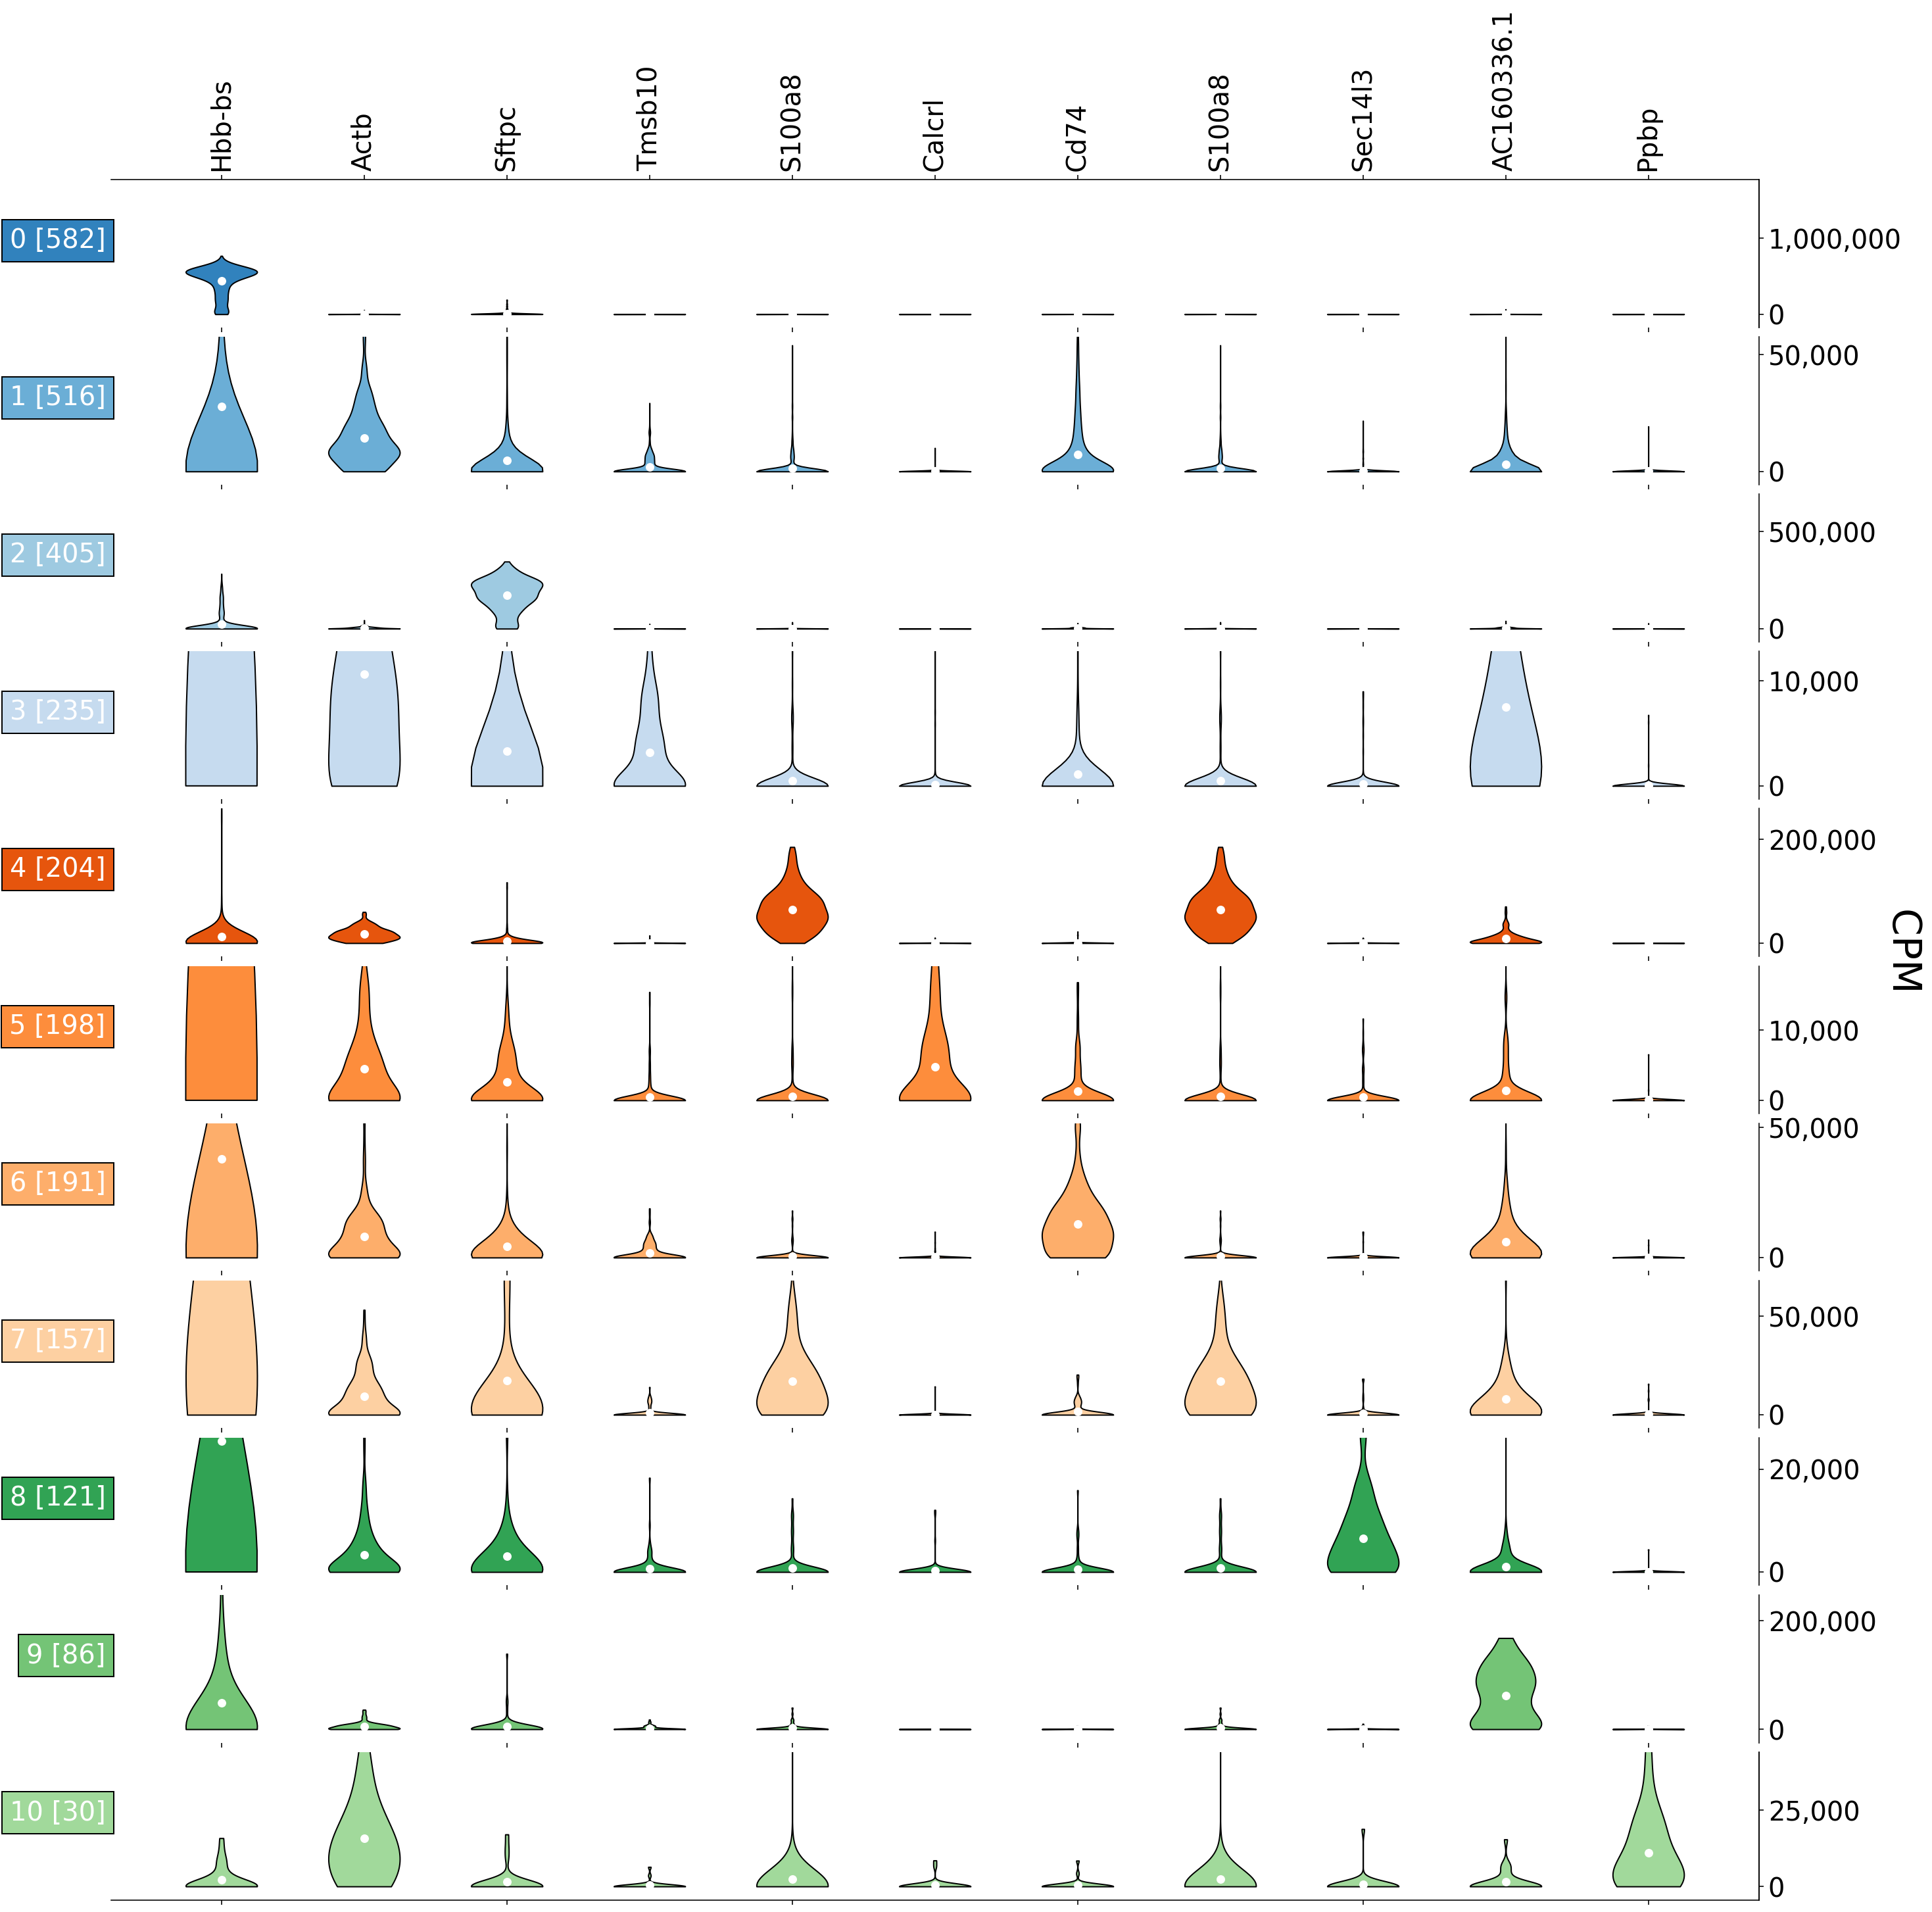

In [0]:
fig, axs = plt.subplots(figsize=(20,20), nrows=len(unique))
fig.subplots_adjust(wspace=0, hspace=0)


labels = specific_gene
lidx = np.arange(0, len(top_idx), 1)
means = []

for cidx, (c, ax) in enumerate(zip(unique, axs)):
    tmp_mat = mat[obs.leiden==str(c),:]
    
    x = tmp_mat[:,top_idx]
    means.append(nd(np.median(x,axis=0)))

    v = ax.violinplot(x.T.tolist(), showmedians=False, showextrema=False, positions=lidx)

    for pcidx, pc in enumerate(v['bodies']):
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        pc.set_facecolor(cm.tab20c(cidx))
        

    means = [np.mean(i) for i in x.T]
    ax.scatter(lidx, means, marker='o', color='white', s=30, zorder=3)
 
    if cidx==0:
        ax_top = ax.twiny()
        ax_top.set_xlim(ax.get_xlim())
        ax_top.set_xticks(lidx)
        ax_top.set_xticklabels(labels, rotation=90, ha="center")
        ax_top.spines["top"].set_visible(True)
        ax_top.spines["left"].set_visible(False)
        ax_top.spines["bottom"].set_visible(False)
    if cidx == len(unique)-1:
        ax_bot = ax.twiny()
        ax_bot.set_xticks([])
        ax_bot.set_xticklabels([])
        ax_bot.spines["top"].set_visible(False)
        ax_bot.spines["left"].set_visible(False)
        ax_bot.spines["bottom"].set_visible(True)

    ax.set_xticklabels("")
    ax.yaxis.tick_right()
    ax.set_ylabel("{} [{:,}]".format(c, x.shape[0]), color="white",rotation="horizontal", ha="right",bbox=dict(boxstyle="square",ec="black",fc=cm.tab20c(cidx)))
    

    
    lim = nd(x.mean(axis=0))[cidx]*4
    
    ax.set_ylim(-lim*0.1, lim)
    
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

        
    
    

plt.tight_layout(pad=0, w_pad=0, h_pad=0)
fig.text(1, 0.5, 'CPM ', ha='center', va='center', rotation=270, fontsize=30)
plt.show()

Note that as a result of the analysis the adata object has accumulated several annotations:

In [0]:
data

AnnData object with n_obs × n_vars = 2725 × 12515 
    obs: 'cell_counts', 'n_genes', 'percent_mito', 'pass_count_filter', 'pass_mito_filter', 'leiden'
    var: 'gene_id', 'gene_name', 'gene_counts', 'n_cells', 'pass_gene_filter', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'neighbors', 'leiden', 'rank_genes_groups'
    obsm: 'X_pca', 'X_pca_tsne', 'X_nca', 'X_nca_tsne'
    layers: 'raw', 'norm', 'log1p', 'scale'

In [0]:
# Running time of the notebook
print("{:.2f} minutes".format((time.time()-start_time)/60))

27.66 minutes


**Feedback**: please report any issues, or submit pull requests for improvements, in the [Github repository where this notebook is located](https://github.com/pachterlab/kallistobustools/blob/master/notebooks/kb_analysis_0_python.ipynb).

# Exercises

1. Reproducibility in science is important and sharing of data even more so. To facilitate the sharing of data, AnnData has a built in function to save the `data` objecte that we have been computing on. Navigate to https://icb-anndata.readthedocs-hosted.com/en/stable/index.html# and save the `data` object as an `h5ad` object.

2. Sometimes results can differ when using different models for differential expression. Above we looked at marker genes when using Wilcoxon rank sum test. Check to see if the results differ when using a t-test instead. Do the clusters have the same top marker?

3. The marker gene of interest isn't necessarily the most differentially expressed marker. List out the other markers to see if you can identify the cell type corresponding to that cluster.

4. We visualized our data using NCA and T-SNE. How does the visualization change if you change the number of NCA dimensions? What if instead of NCA to TSNE  you did PCA to TSNE? How do the results differ?

5. Differential expression was performed using the $log(CPM +1)$ count matrix. Do the results change if instead just the CPM matrix is used? Compare the differentially expressed genes for each cluster. Note you can see how to change the specific anndata layer that is used in performing DE at the ScanPy docs: https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.tl.rank_genes_groups.html.